# Classification & Prediction of CO2 Emissions Using 
# Ridge, Lasso, Elastic Net and Random Forest Regressor

## Setup

In [1]:
# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Print multiple outputs per cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
def score_model(model, x_train, y_train, x_test, y_test):
        ## Score for training data set
        y_pred_train = model.predict(x_train)

        print("#### Training dataset scores ####")
        try:
            print(f"The intercept for model is {model.intercept_:.4f}")
        except:
            pass
        print(f'Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train):.6f}')  
        print(f'Mean Squared Error: {mean_squared_error(y_train, y_pred_train):.6f}')  
        print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.6f}')
        print(f'R2 score: {model.score(x_train, y_train):.6f}')
        print()
        print("Training dataset validation")
        df= pd.DataFrame({'Actual':y_train,'Predictions':y_pred_train})
        df['Predictions']= round(df['Predictions'],2)
        print(df.head(20))
        print()
        print()

        ## Score for testing data set
        y_pred_test = model.predict(x_test)

        print("#### Testing dataset scores ####")
        try:
            print(f"The intercept for model is {model.intercept_:.4f}")
        except:
            pass
        print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred_test):.6f}')  
        print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred_test):.6f}')  
        print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.6f}')
        print(f'R2 score: {model.score(x_test, y_test):.6f}')
        print()
        print("Testing dataset validation")
        df= pd.DataFrame({'Actual':y_test,'Predictions':y_pred_test})
        df['Predictions']= round(df['Predictions'],2)
        print(df.head(20))
        print()
        print()
        

## Merged Dataset Creation

In [ ]:
#### Top 5 Countries: United States, China, Japan, Germany, India ####
debug=True

keep_countries = ["United States", "China", "Japan", "Germany", "India"]
keep_metrics = ["country", "year", "co2", "population", "gdp", "primary_energy_consumption"]

# Import main co2 dataset
co2 = pd.read_csv("data/owid-co2-data.csv")

co2 = co2[keep_metrics]

if debug:
    co2.info()

In [ ]:
co2 = co2[co2["country"].isin(keep_countries)]

if debug:
    display(co2.sample(10))

In [ ]:
#  Load Coal Production Dataset

coal = pd.read_csv("data/coal-production-by-region.csv")
coal = coal.drop(["Code"], axis=1)

if debug:
    coal.info()

In [ ]:
coal = coal[coal["Entity"].isin(keep_countries)]
coal = coal.rename(columns={"Entity": "country", "Year": "year"})

if debug:
    display(coal.sample(10))

In [ ]:
co2_coal = pd.merge(co2, coal, on=["country", "year"], how="outer")

if debug:
    co2_coal.info()
    display(co2_coal.sample(10))

In [ ]:
# Load Oil Consumption

oil = pd.read_csv("data/oil-consumption-by-country.csv")
oil = oil.drop(["Code"], axis=1)

if debug:
    oil.info()

In [ ]:
oil = oil[oil["Entity"].isin(keep_countries)]
oil = oil.rename(columns={"Entity": "country", "Year": "year"})

if debug:
    display(oil.sample(10))

In [ ]:
co2_coal_oil = pd.merge(co2_coal, oil, on=["country", "year"], how="outer")

if debug:
    co2_coal_oil.info()
    display(co2_coal_oil.sample(10))

In [ ]:
# Load Coal Consumption Dataset

coal_cons = pd.read_csv('data/world-coal-consumption-1978-2020.csv')

# Comment out this line to include EU27 countries
coal_cons = coal_cons.drop(["EU27"], axis=1)
    
coal_cons = pd.melt(coal_cons, id_vars=["Year"], var_name="country", value_name="Coal Consumption - TWh")
coal_cons = coal_cons.rename(columns={"Year": "year"})

# Dataset gave values in Terajoules (supposedly??), converting to TWh
coal_cons["Coal Consumption - TWh"] = coal_cons["Coal Consumption - TWh"] / 3600

coal_cons.sample(10)

In [ ]:
merged = pd.merge(co2_coal_oil, coal_cons, on=["country", "year"], how="outer")

if debug:
    merged.info()
    display(merged.sample(10))

In [ ]:
# Load Coal Consumption Dataset

cars = pd.read_csv('data/car_production.csv')

cars = pd.melt(cars, id_vars=["country"], var_name="year", value_name="Cars Produced - Thousands")
cars["year"] = pd.to_numeric(cars["year"])  

if debug:
    cars.info()
    display(cars.sample(10))

In [ ]:
final = pd.merge(merged, cars, on=["country", "year"], how="outer")

if debug:
    final.info()
    display(final.sample(10))

In [ ]:
# Export

final.to_csv('dataset.csv', index=False) 

## Data Preparation

In [3]:
final=pd.read_csv(r"../input/final-data-after-preprocessing/dataset.csv")

In [4]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     888 non-null    object 
 1   year                        888 non-null    int64  
 2   co2                         875 non-null    float64
 3   population                  880 non-null    float64
 4   gdp                         724 non-null    float64
 5   primary_energy_consumption  275 non-null    float64
 6   Coal Production - TWh       200 non-null    float64
 7   Oil Consumption - TWh       280 non-null    float64
 8   Coal Consumption - TWh      172 non-null    float64
 9   Cars Produced - Thousands   155 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 69.5+ KB


In [5]:
final.isna().sum()

country                         0
year                            0
co2                            13
population                      8
gdp                           164
primary_energy_consumption    613
Coal Production - TWh         688
Oil Consumption - TWh         608
Coal Consumption - TWh        716
Cars Produced - Thousands     733
dtype: int64

In [6]:
final.describe()

,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh
count,888.000000,875.000000,8.800000e+02,7.240000e+02,275.000000,200.000000,280.000000,172.000000
mean,1926.950450,988.530721,2.677760e+08,2.140407e+12,9645.127495,4147.882140,3464.591754,5.035815
std,58.852728,1744.578106,3.421499e+08,3.459539e+12,9373.407894,5364.788045,3314.434887,5.743050
min,1792.000000,0.011000,6.000000e+06,2.668967e+10,616.017000,4.893107,129.062536,0.444705
25%,1884.750000,28.587000,5.082469e+07,2.566350e+11,3729.211500,542.562560,1297.874098,1.280155
50%,1932.000000,220.712000,1.049918e+08,6.152506e+11,4856.292000,1782.474436,1991.874998,3.839166
75%,1976.000000,1045.795000,3.280095e+08,2.535874e+12,15859.317500,6062.563019,4226.491485,5.834072
max,2020.000000,10667.887000,1.439324e+09,1.815162e+13,39360.925000,22475.080114,11214.078236,24.343903


## Fix Missing Data

#### Option 1
#### Interpolate with Linear Method in forward direction

In [7]:
option_1 = final.copy()
option_1 = option_1.interpolate(method="linear", limit_direction ='forward')
option_1.isnull().sum()

country                         0
year                            0
co2                             0
population                      0
gdp                             1
primary_energy_consumption     66
Coal Production - TWh          82
Oil Consumption - TWh          66
Coal Consumption - TWh         79
Cars Produced - Thousands     733
dtype: int64

In [8]:
option_1.describe()

,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh
count,888.000000,888.000000,8.880000e+02,8.870000e+02,822.000000,806.000000,822.000000,809.000000
mean,1926.950450,974.074128,2.719281e+08,2.214440e+12,10685.207618,4774.615764,3238.775775,7.362645
std,58.852728,1735.807802,3.450945e+08,3.653493e+12,9555.589054,5821.075541,2560.799160,6.908899
min,1792.000000,0.011000,6.000000e+06,2.668967e+10,616.017000,4.893107,129.062536,0.444705
25%,1884.750000,24.768750,5.141600e+07,2.319887e+11,3746.412818,670.375275,1312.043420,2.247800
50%,1932.000000,205.729500,1.080558e+08,5.280018e+11,7134.121160,2485.929892,2422.588984,3.980166
75%,1976.000000,1035.912500,3.348168e+08,2.565860e+12,13933.216909,6023.075255,4747.493041,11.643186
max,2020.000000,10667.887000,1.439324e+09,1.815162e+13,39360.925000,22475.080114,11214.078236,24.343903


In [9]:
option_1.fillna(0, inplace=True)

#### Option 2
#### Interpolate with Linear Method both directions

In [10]:
option_2 = final.copy()
option_2 = option_2.interpolate(method="linear", limit_direction ='both')

In [11]:
option_2.isna().sum()

country                         0
year                            0
co2                             0
population                      0
gdp                             0
primary_energy_consumption      0
Coal Production - TWh           0
Oil Consumption - TWh           0
Coal Consumption - TWh          0
Cars Produced - Thousands     733
dtype: int64

In [12]:
option_2.fillna(0, inplace=True)

#### Option 3
#### Using Simpleimputer to impute missing values

In [13]:
option_3 = final.copy()

In [14]:
categorical_list = []
numerical_list = []

for i in option_3.columns.tolist():
    if option_3[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
        
print(f'Number of numerical features: {str(len(numerical_list))}')
print(f'Number of categorical features: {str(len(categorical_list))}')

Number of numerical features: 8
Number of categorical features: 2


In [15]:
from sklearn.impute import SimpleImputer

option_3[numerical_list] = SimpleImputer(strategy='median').fit_transform(option_3[numerical_list])
option_3.isna().sum()

country                         0
year                            0
co2                             0
population                      0
gdp                             0
primary_energy_consumption      0
Coal Production - TWh           0
Oil Consumption - TWh           0
Coal Consumption - TWh          0
Cars Produced - Thousands     733
dtype: int64

In [16]:
## Inspecting missing values for Cars Produced

option_3[option_3["Cars Produced - Thousands"].isnull()][:20]

,country,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh,Cars Produced - Thousands
0,China,1899.0,0.095,399421783.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
1,China,1900.0,220.712,401579661.0,3.888000e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
2,China,1901.0,220.712,403786465.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
3,China,1902.0,0.095,406042669.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
4,China,1903.0,1.964,408348748.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
5,China,1904.0,2.088,410667922.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
6,China,1905.0,2.297,413000265.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
7,China,1906.0,17.111,415345852.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
8,China,1907.0,16.840,417704759.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
9,China,1908.0,22.731,420077060.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN


In [17]:
option_3.fillna(0, inplace=True)

## Boxplots for select variables across Options 1-3

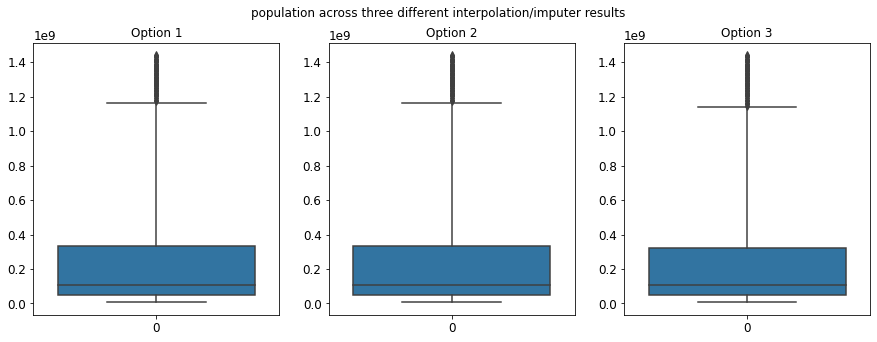

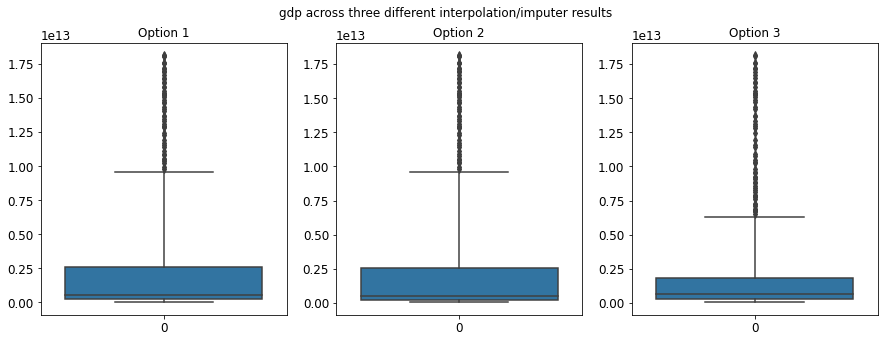

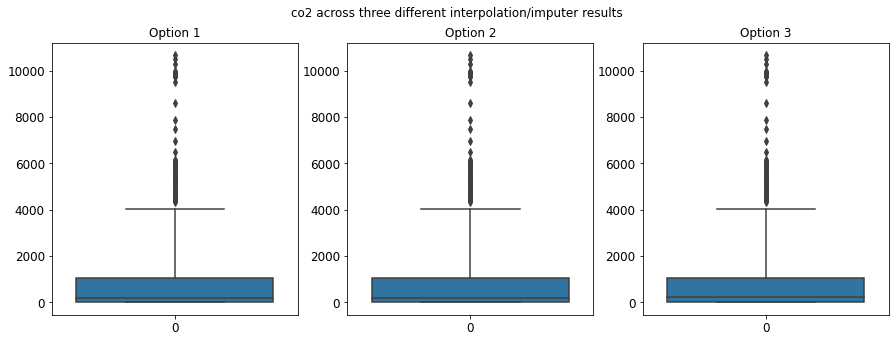

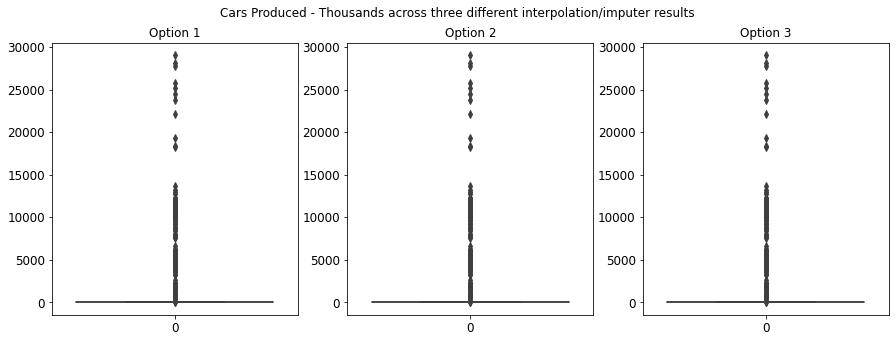

In [18]:
_vars = ['population', 'gdp', 'co2', 'Cars Produced - Thousands']

option_1 = option_1[option_1["Cars Produced - Thousands"] != 'U']
option_2 = option_2[option_2["Cars Produced - Thousands"] != 'U']
option_3 = option_3[option_3["Cars Produced - Thousands"] != 'U']

for i in _vars:
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
    fig.suptitle(f'{i} across three different interpolation/imputer results')

    sns.boxplot(ax=axes[0], data = option_1[i], whis=3)
    axes[0].set_title("Option 1")
    
    sns.boxplot(ax=axes[1], data = option_2[i], whis=3)
    axes[1].set_title("Option 2")
    
    sns.boxplot(ax=axes[2], data = option_3[i], whis=3)
    axes[2].set_title("Option 3");
    
    print()

### Correleation Heatmaps
#### Determining which option has the highest correlations

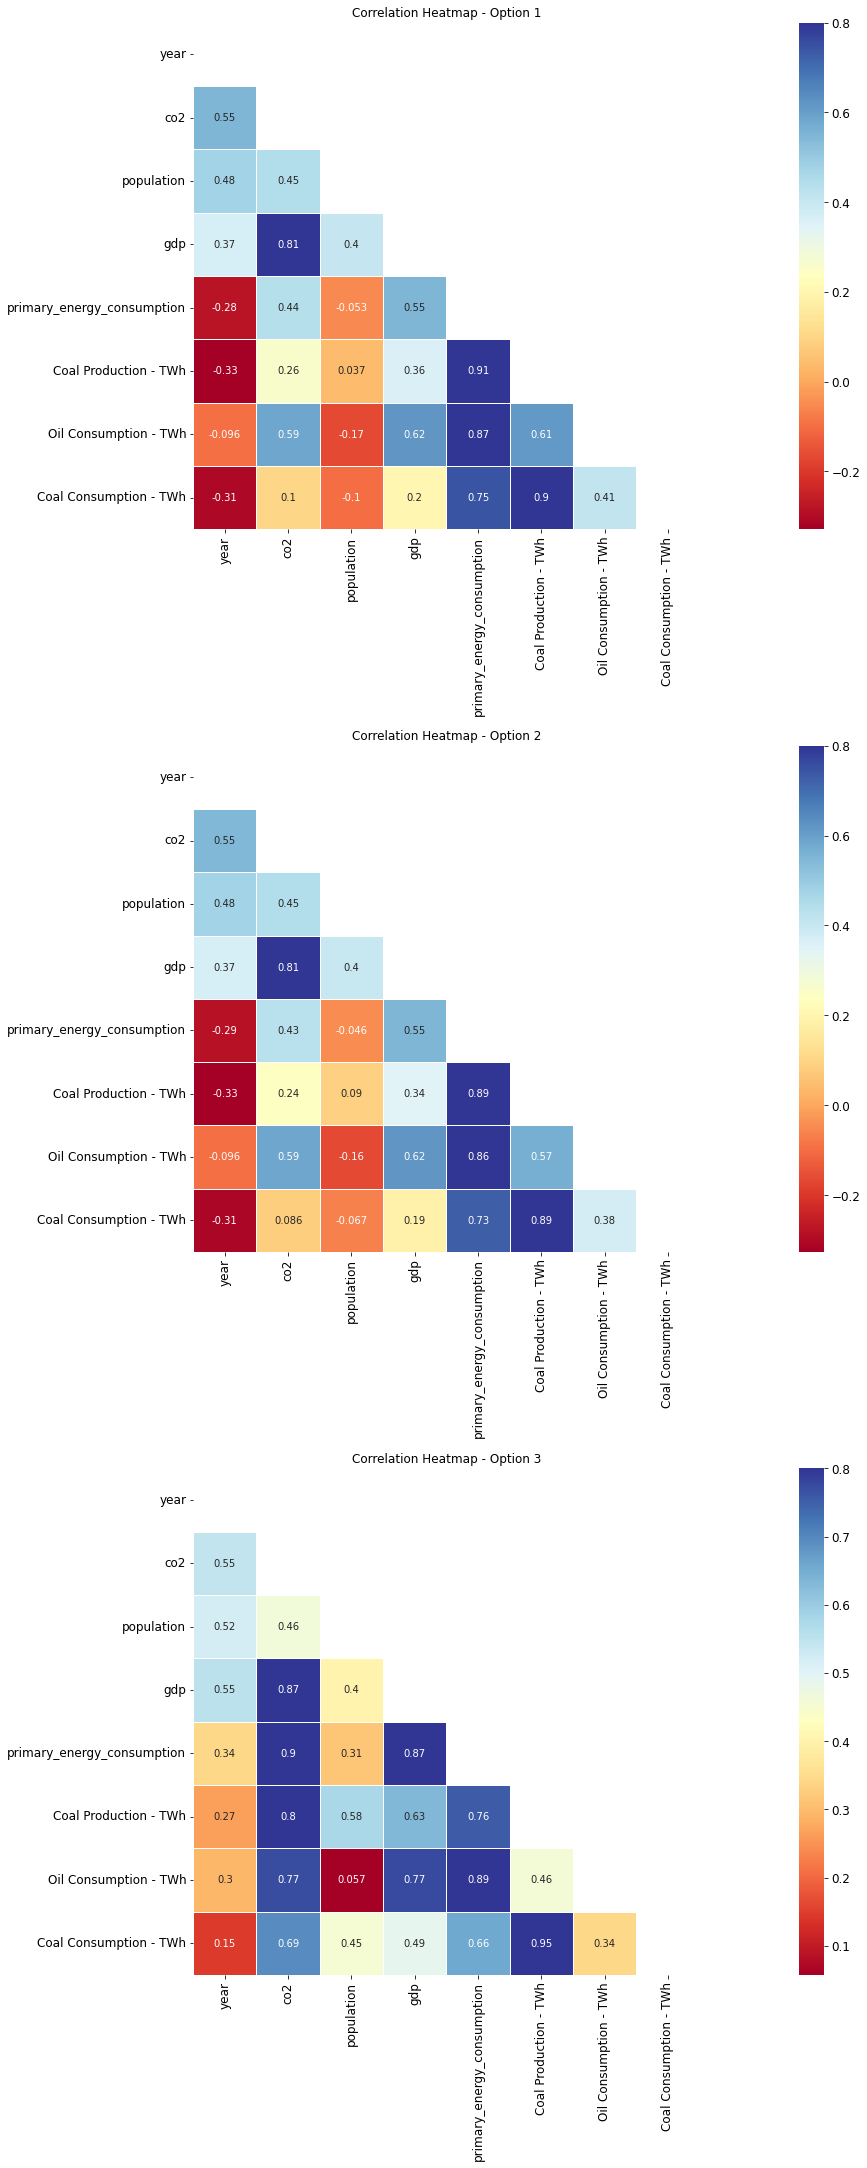

In [19]:
options = [option_1, option_2, option_3]

f, ax = plt.subplots(3, 1, figsize=(30,30), constrained_layout=True)

for i, opt in enumerate(options):
    cm = opt.corr()

    ## creating a mask to only see relationship between few variables
    mask= np.triu(np.ones_like(cm, dtype=bool))

    ## creating heat map using a mask
    sns.heatmap(cm, ax=ax[i], vmax=.8, square=True, mask = mask, annot=True, cmap='RdYlBu', linewidths=.9 )
    ax[i].set_title(f'Correlation Heatmap - Option {i+1}')

### Option 4 - Filtering data before 19XX

#### Much of the `null` values seem to come from years before 1950. We can iterate each decade and determine what year to start dropping data from.

In [20]:
decades = []

for i in range(1980, 1920, -10):
    tmp = final[final.year > i]
    decades.append(tmp)
    
    print(f'\n>{i}')
    display(tmp.isna().sum())
    print(f'\rTotal nulls: {tmp.isna().sum().sum()}')


>1980


country                        0
year                           0
co2                            0
population                     0
gdp                           10
primary_energy_consumption     5
Coal Production - TWh          0
Oil Consumption - TWh          0
Coal Consumption - TWh        40
Cars Produced - Thousands     55
dtype: int64

Total nulls: 110

>1970


country                         0
year                            0
co2                             0
population                      0
gdp                            10
primary_energy_consumption      5
Coal Production - TWh          50
Oil Consumption - TWh           0
Coal Consumption - TWh         78
Cars Produced - Thousands     100
dtype: int64

Total nulls: 243

>1960


country                         0
year                            0
co2                             0
population                      0
gdp                            10
primary_energy_consumption     25
Coal Production - TWh         100
Oil Consumption - TWh          20
Coal Consumption - TWh        128
Cars Produced - Thousands     145
dtype: int64

Total nulls: 428

>1950


country                         0
year                            0
co2                             0
population                      0
gdp                            10
primary_energy_consumption     75
Coal Production - TWh         150
Oil Consumption - TWh          70
Coal Consumption - TWh        178
Cars Produced - Thousands     195
dtype: int64

Total nulls: 678

>1940


country                         0
year                            0
co2                             0
population                      0
gdp                            19
primary_energy_consumption    125
Coal Production - TWh         200
Oil Consumption - TWh         120
Coal Consumption - TWh        228
Cars Produced - Thousands     245
dtype: int64

Total nulls: 937

>1930


country                         0
year                            0
co2                             0
population                      0
gdp                            21
primary_energy_consumption    175
Coal Production - TWh         250
Oil Consumption - TWh         170
Coal Consumption - TWh        278
Cars Produced - Thousands     295
dtype: int64

Total nulls: 1189


In [21]:
## Filling missing values with 0

for dec in decades:
    dec.fillna(0, inplace=True)

### Correleation Map shows that Option 4 has stronger correleation compared to others
##### Moving forward with inspecting data from 1980 since it has the least amount of missing data

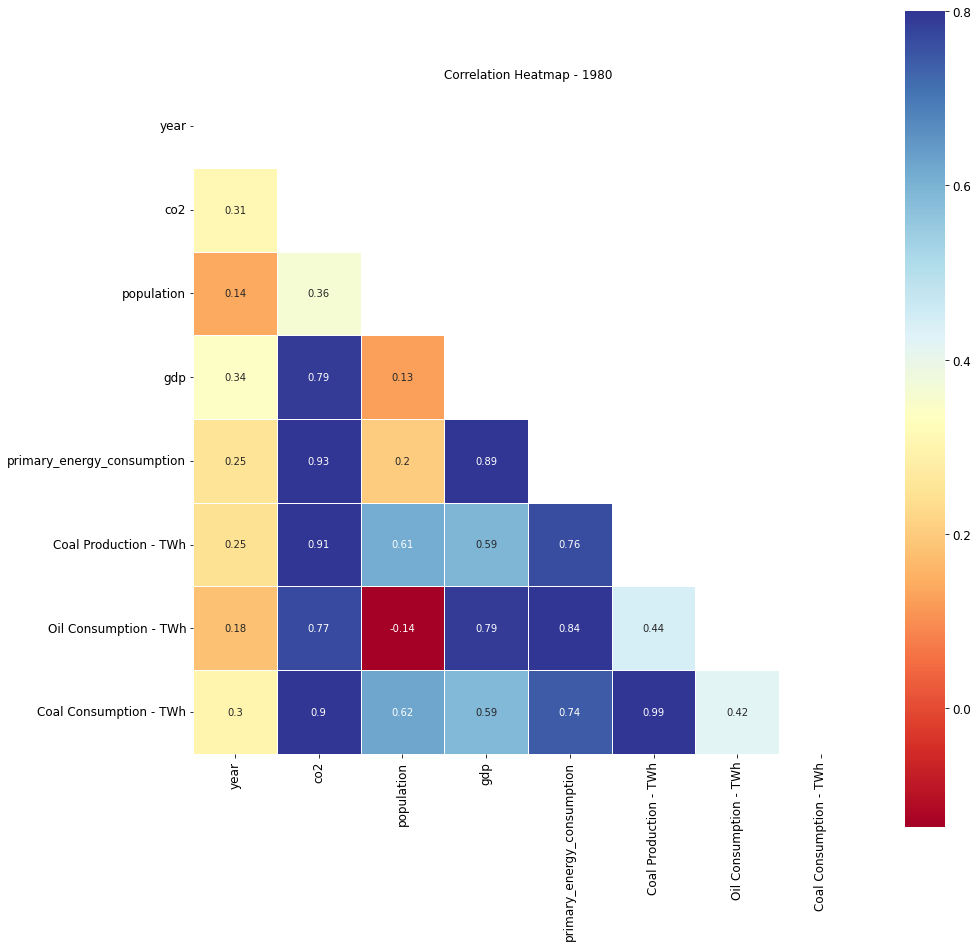

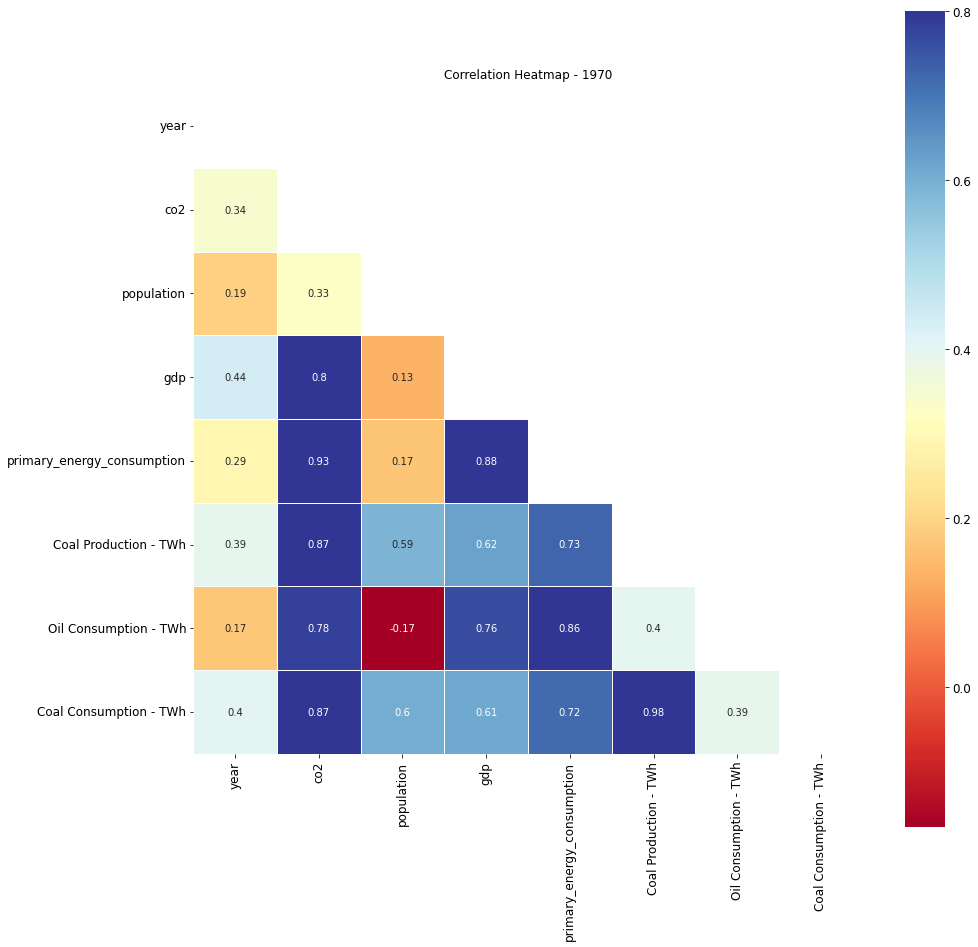

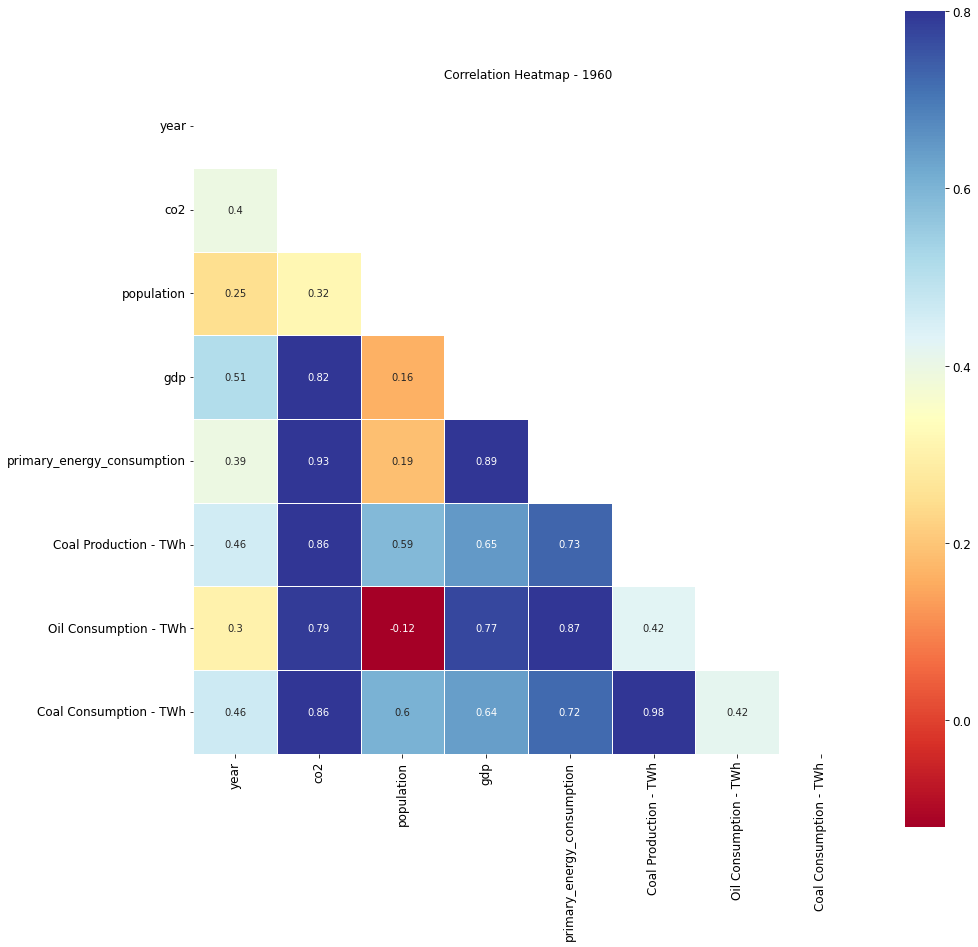

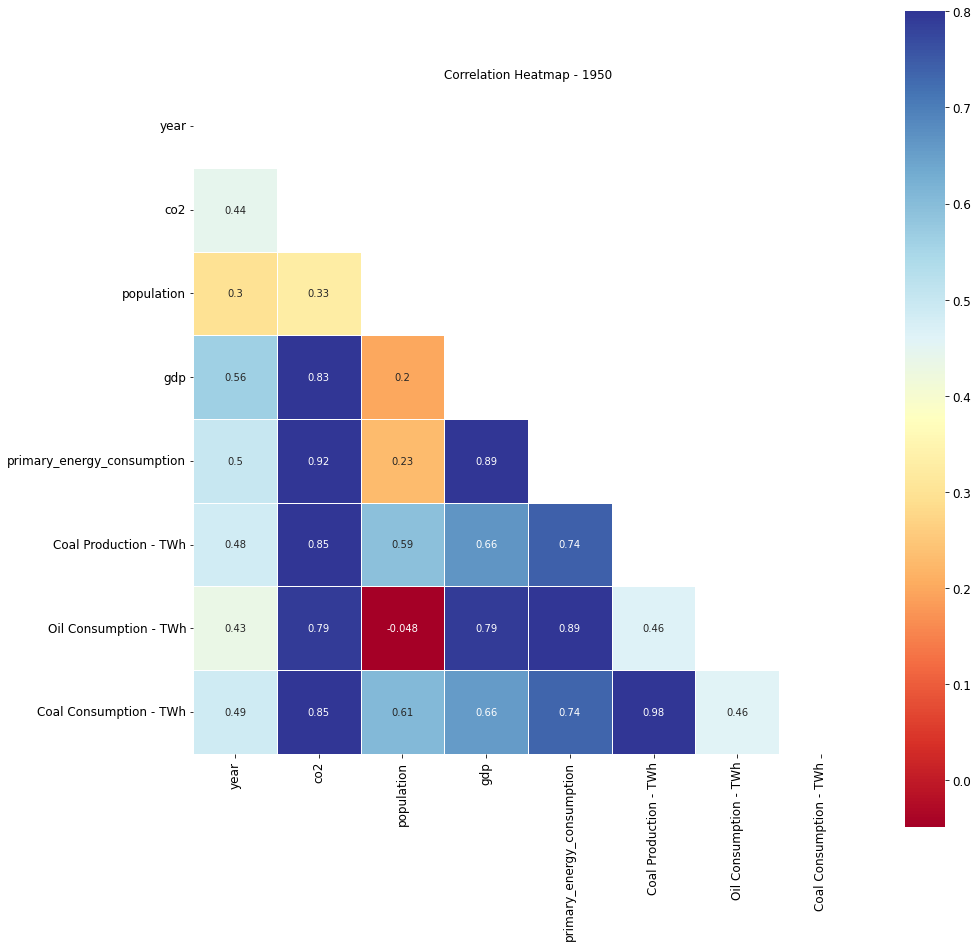

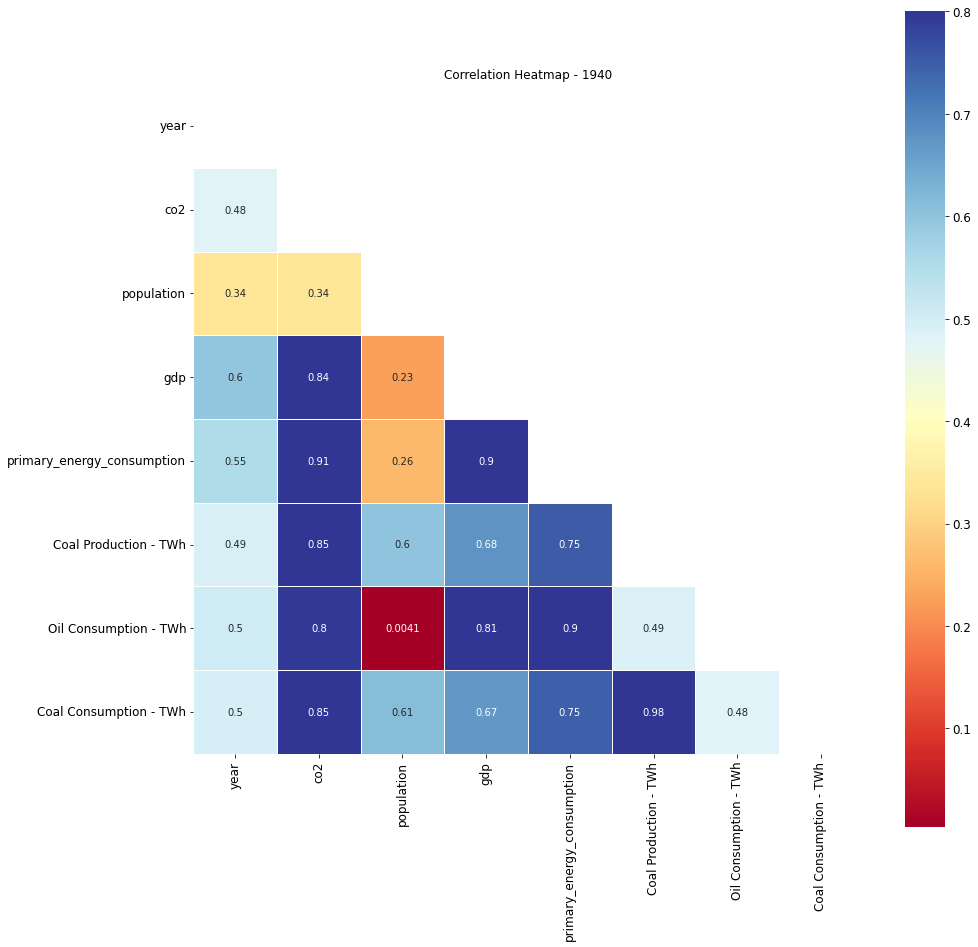

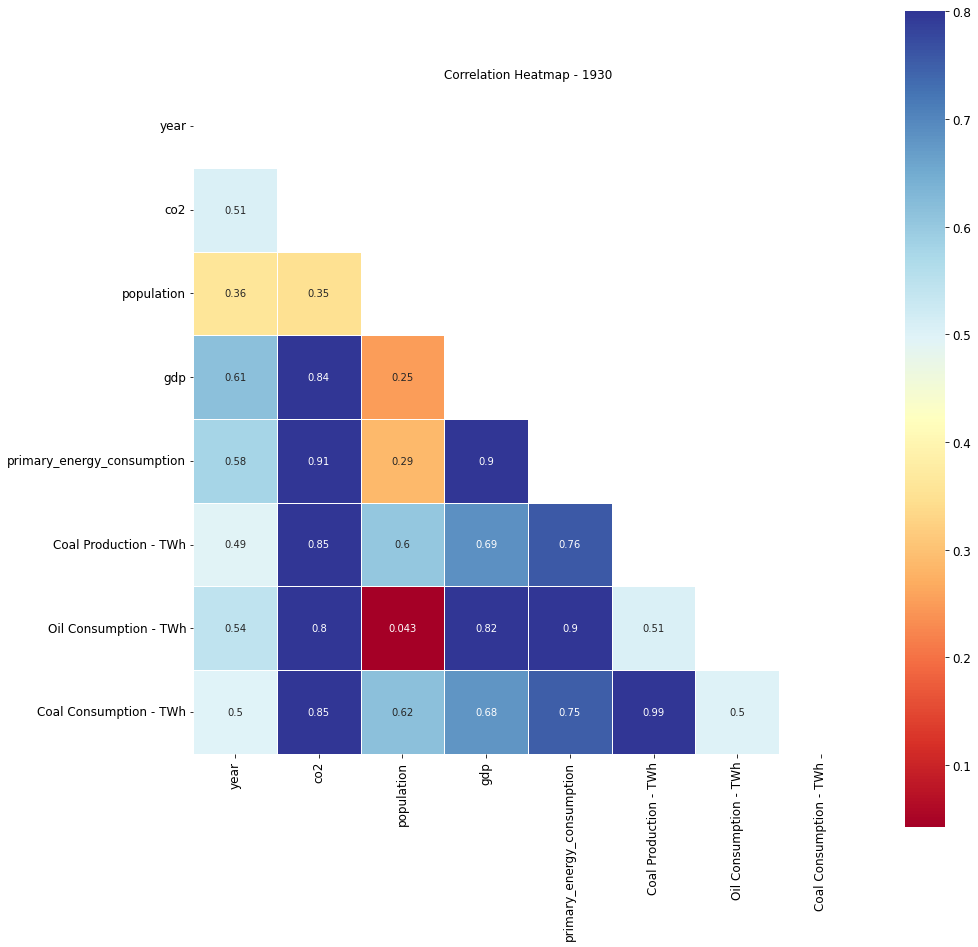

In [22]:
i = 1980

for df in decades:
    cm = df.corr()
    mask= np.triu(np.ones_like(cm, dtype=bool))

    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(cm, vmax=.8, square=True, mask = mask, annot=True, cmap='RdYlBu', linewidths=.9 )
    plt.title(f'Correlation Heatmap - {i}')
    i = i - 10


In [23]:
final_1980 = decades[0]

final_1980.reset_index().to_csv('final_1980.csv')

In [24]:
option_4 = final_1980.reset_index().copy()

#### Comparing Box Plots of option 4 with other three options

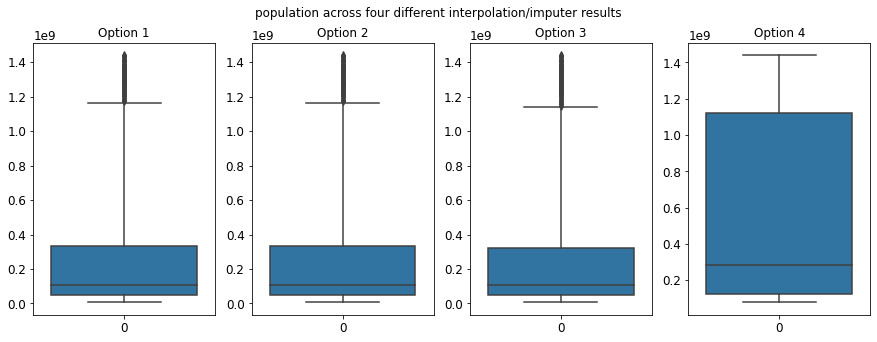

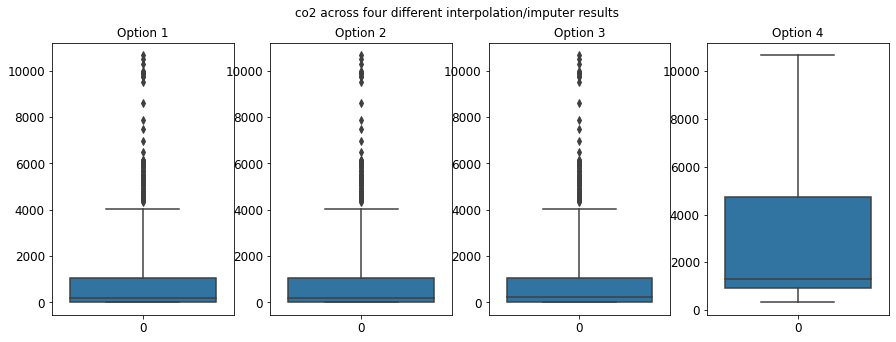

In [25]:
_vars = ['population', 'co2']

for i in _vars:
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(15,5))
    fig.suptitle(f'{i} across four different interpolation/imputer results')

    sns.boxplot(ax=axes[0], data = option_1[i], whis=3)
    axes[0].set_title("Option 1")
    
    sns.boxplot(ax=axes[1], data = option_2[i], whis=3)
    axes[1].set_title("Option 2")
    
    sns.boxplot(ax=axes[2], data = option_3[i], whis=3)
    axes[2].set_title("Option 3");
    
    sns.boxplot(ax=axes[3], data = option_4[i], whis=3)
    axes[3].set_title("Option 4");
    
    print()

### Inspecting CO2 variable for option 4 to see if there are truly outliers

#### Although the boxplot for CO2 shows outliers, this might be actual data becasue China is one of the worlds largest CO2 producers;  this finding makes sense

In [26]:
option_4[option_4["co2"] > 6500][:20]

,index,country,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh,Cars Produced - Thousands
26,108,China,2007,6978.612,1.345994e+09,1.035821e+13,25024.414,16738.864931,4381.042547,17.182822,8885.461
27,109,China,2008,7496.832,1.353569e+09,1.079915e+13,25956.957,17349.282742,4469.130244,17.488486,9233.29
28,110,China,2009,7886.533,1.361169e+09,1.157254e+13,27089.785,17885.351892,4637.320094,18.835860,13648.553
29,111,China,2010,8616.653,1.368811e+09,1.285881e+13,28967.802,19367.248989,5275.544381,20.819195,18264.667
30,112,China,2011,9528.556,1.376498e+09,1.367316e+13,31261.361,21535.067208,5467.327189,22.674968,18418.876
31,113,China,2012,9775.622,1.384206e+09,1.435813e+13,32512.623,21789.302833,5731.219008,23.027610,19271.808
32,114,China,2013,9952.744,1.391883e+09,1.530443e+13,33715.209,22034.135553,5982.918831,23.743987,22116.825
33,115,China,2014,9985.583,1.399454e+09,1.622086e+13,34499.453,21680.762764,6218.294911,23.831354,23722.89
34,116,China,2015,9848.420,1.406848e+09,1.671095e+13,34826.942,21273.959439,6732.650186,23.311231,24503.326
35,117,China,2016,9720.444,1.414049e+09,1.725547e+13,35264.122,19671.231811,6961.925881,22.370055,28118.794


#### Using option 4 for all data analysis

In [27]:
option_4['co2'].describe()

count      200.00000
mean      2791.32080
std       2572.65811
min        315.26600
25%        939.60325
50%       1280.99100
75%       4740.93950
max      10667.88700
Name: co2, dtype: float64

#### Since the difference in the Interquartile range is vast, we use the Rank Function to rank CO2 emission to generate category

In [28]:
option_4["Target_Rank"]= option_4["co2"].rank()
option_4["Target_Rank"]= round(option_4["Target_Rank"],0)
option_4["Target_Rank"]= option_4["Target_Rank"].astype(int)
option_4["Target_Rank"].describe()

count    200.000000
mean     100.500000
std       57.879185
min        1.000000
25%       50.750000
50%      100.500000
75%      150.250000
max      200.000000
Name: Target_Rank, dtype: float64

In [29]:
from pandas import Categorical

high_cat= 150
mid_cat= 100.50
low_cat = 50.75

option_4['CO2_Cat'] = Categorical(np.where(option_4['Target_Rank'] < low_cat, 1,2))
option_4['CO2_Cat'] = Categorical(np.where(option_4['Target_Rank'] > low_cat,2,option_4['CO2_Cat']))
option_4['CO2_Cat'] = Categorical(np.where(option_4['Target_Rank'] > mid_cat,3,option_4['CO2_Cat']))
option_4['CO2_Cat'] = Categorical(np.where(option_4['Target_Rank'] > high_cat,4,option_4['CO2_Cat']))

option_4.groupby('CO2_Cat').mean()

,index,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh,Target_Rank
CO2_Cat,,,,,,,,,,
1,430.88,1997.96,752.35056,3.693062e+08,2.469198e+12,3255.79826,741.033923,1316.803158,0.495068,25.5
2,525.30,1998.58,1118.54074,2.685284e+08,3.224273e+12,4801.97750,758.674532,2169.349252,0.919514,75.5
3,382.80,1999.40,2660.74310,9.559142e+08,4.869540e+12,9180.57938,4630.753612,2967.956944,4.784441,125.5
4,612.62,2006.06,6633.64880,6.607363e+08,1.248280e+13,26225.31040,10461.066494,8594.943532,10.585927,175.5


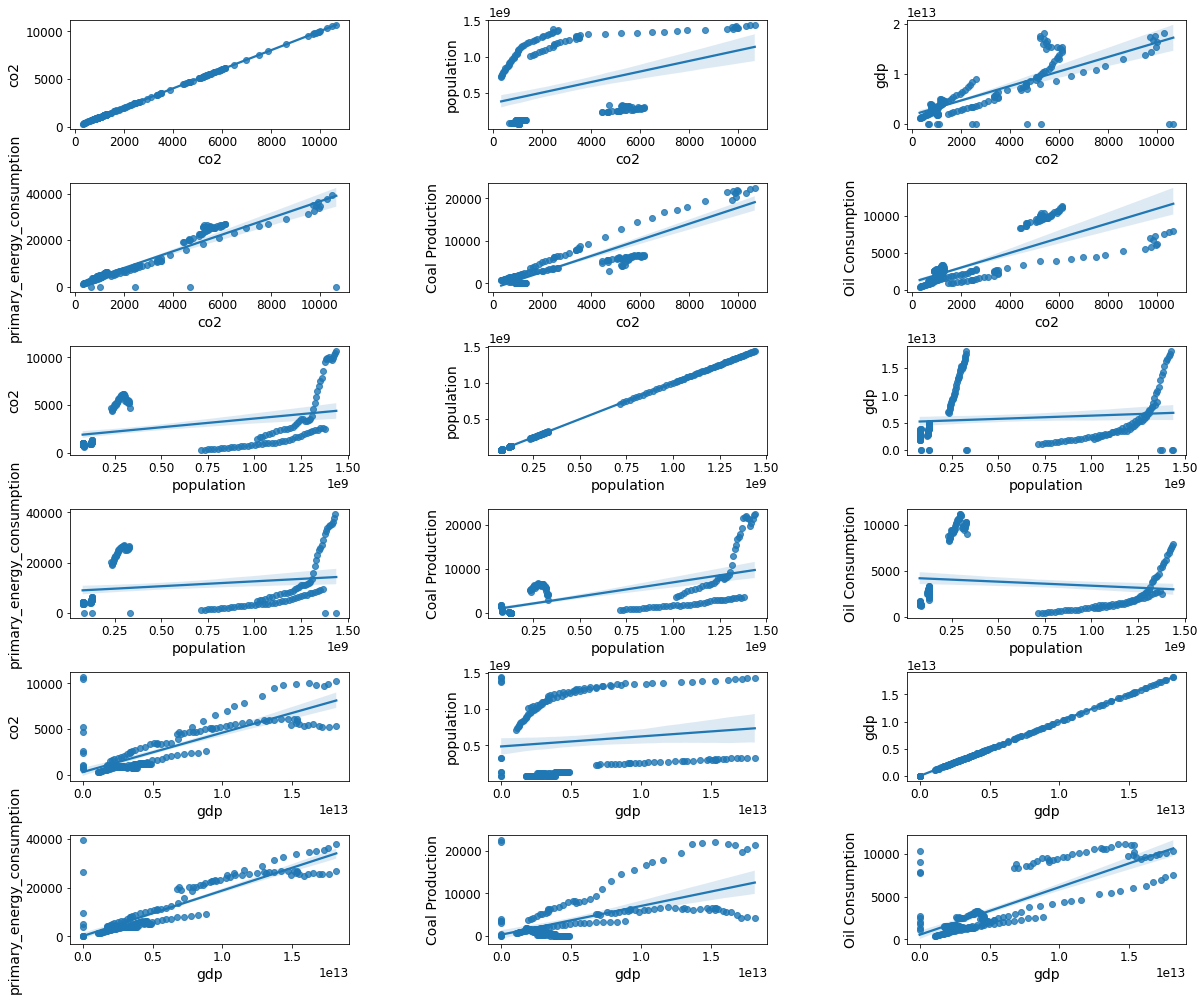

In [30]:
## Generating regression plot

plt.figure(1 , figsize = (20 , 20))
n = 0 
for x in ['co2' , 'population',"gdp"]:
    for y in ['co2' , 'population',"gdp","primary_energy_consumption","Coal Production - TWh" , 'Oil Consumption - TWh']:
        n += 1
        plt.subplot(7 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = option_4)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )

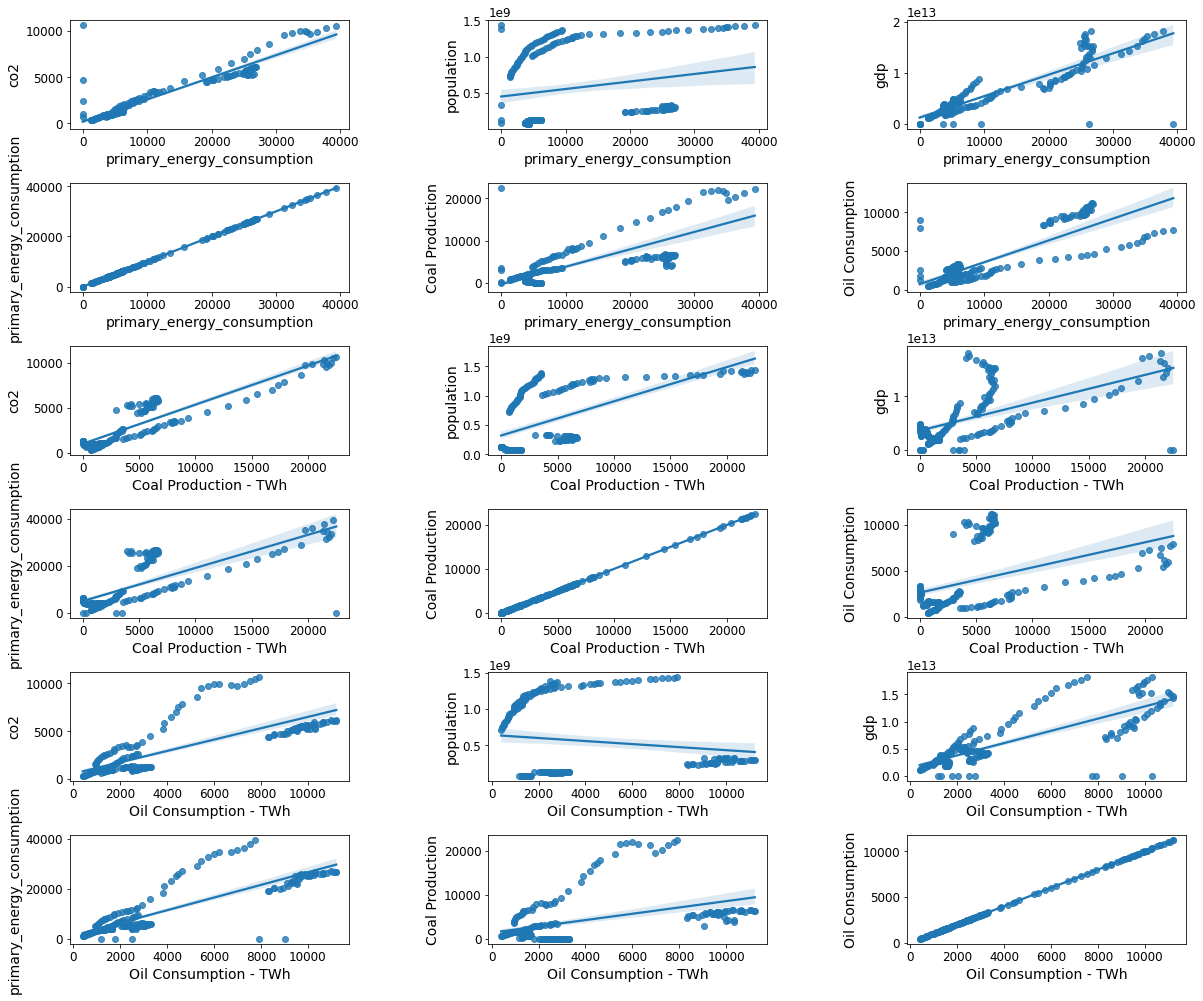

In [31]:
plt.figure(1 , figsize = (20 , 20))
n = 0 
for x in ["primary_energy_consumption","Coal Production - TWh" , 'Oil Consumption - TWh']:
    for y in ['co2' , 'population',"gdp","primary_energy_consumption","Coal Production - TWh" , 'Oil Consumption - TWh']:
        n += 1
        plt.subplot(7 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = option_4)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )

#### Correleation Pair Plot

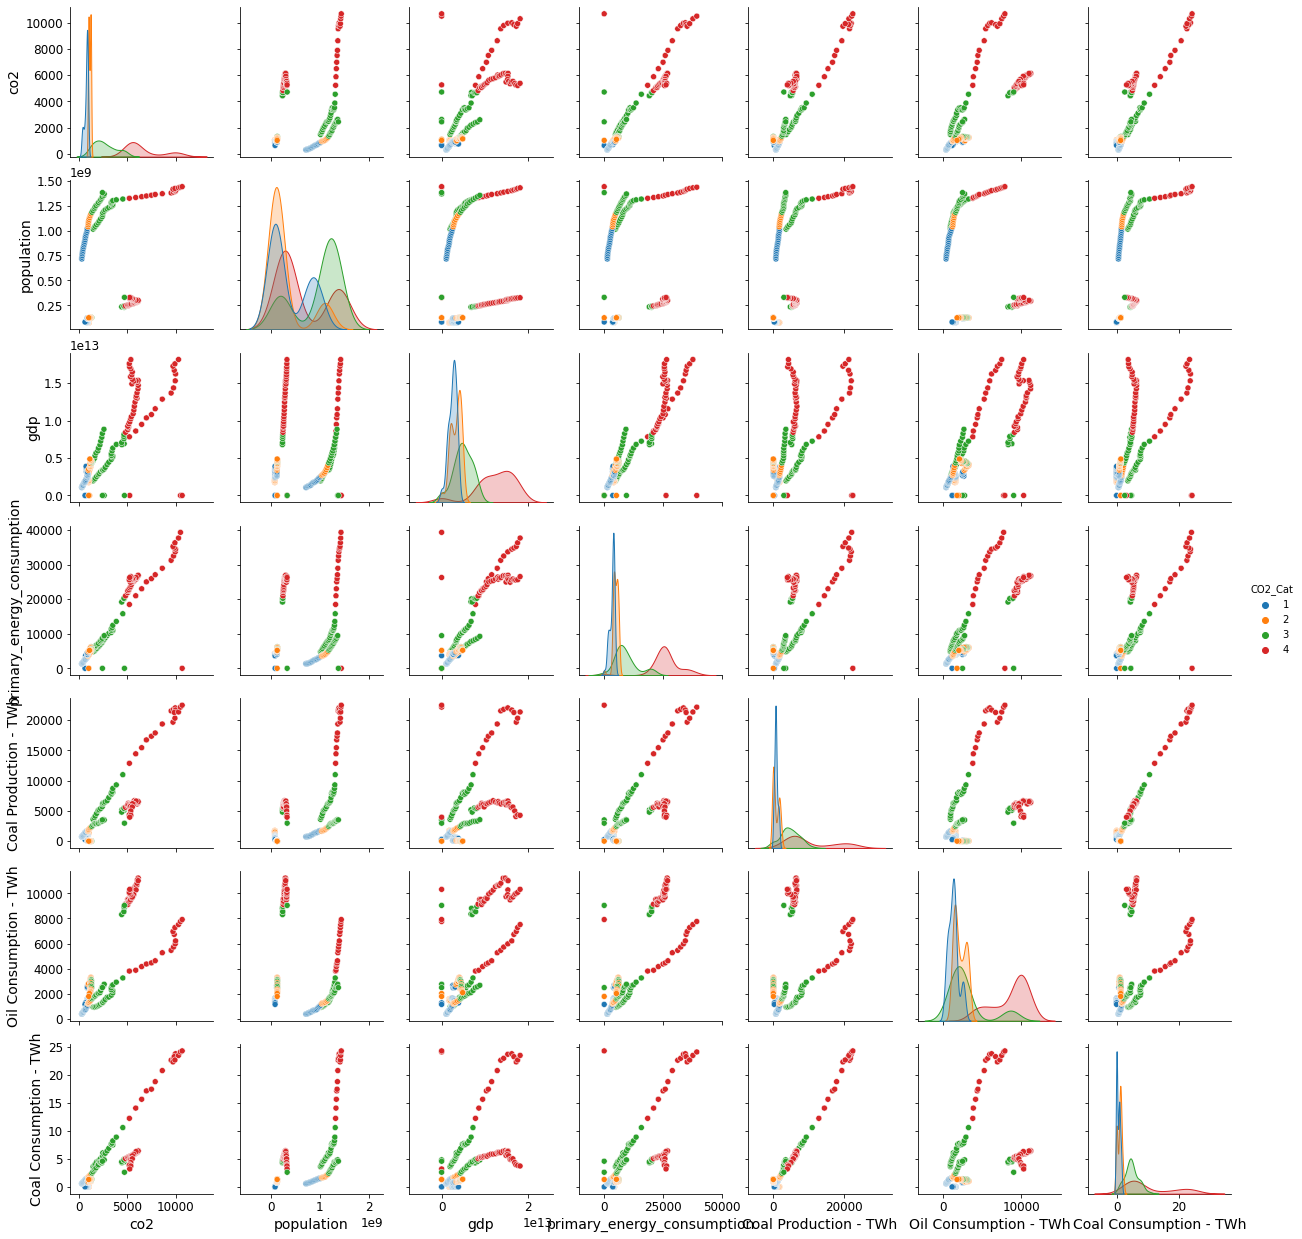

In [32]:
sns.pairplot(option_4, hue='CO2_Cat', vars=["co2","population","gdp","primary_energy_consumption","Coal Production - TWh","Oil Consumption - TWh","Coal Consumption - TWh"]);

#### Generating scatter plots between variables by category

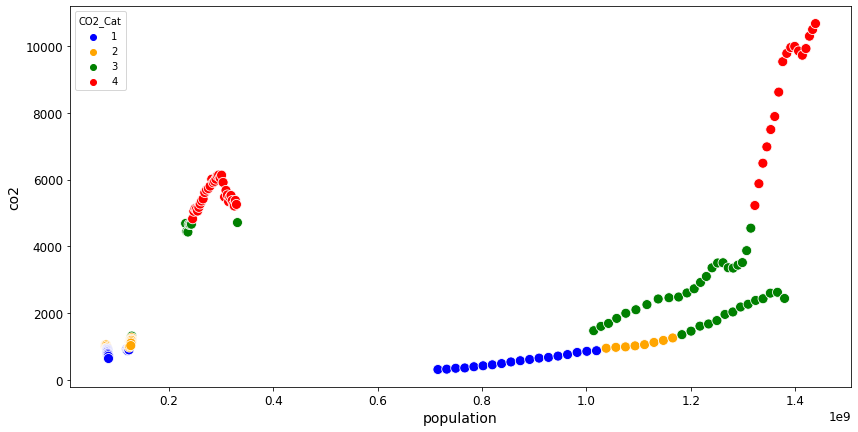

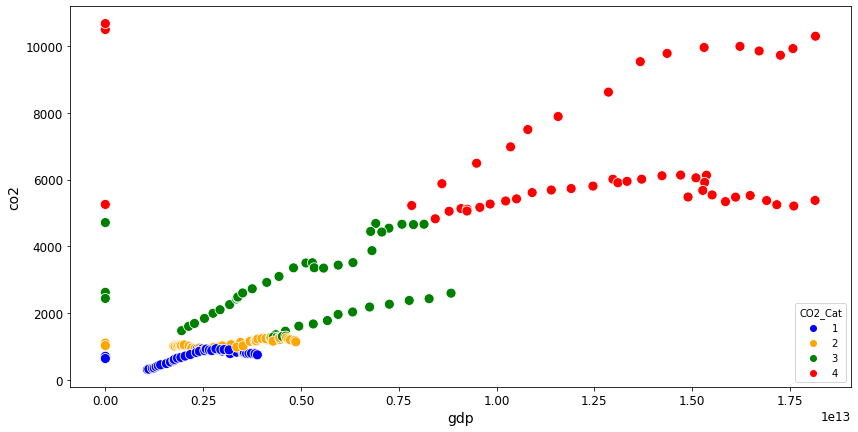

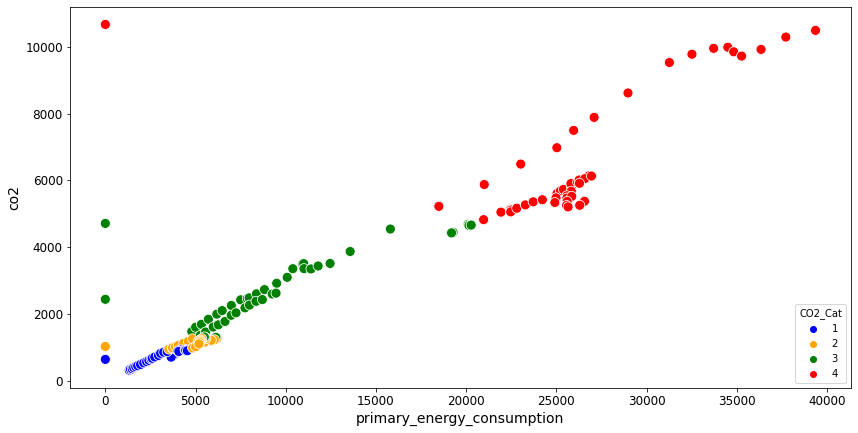

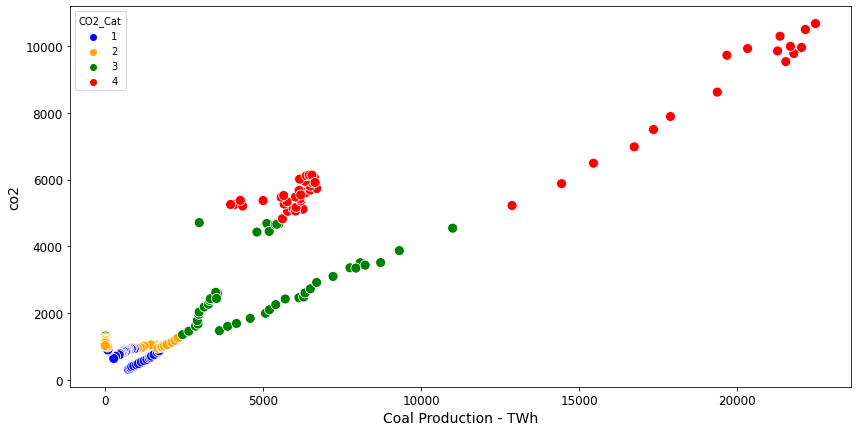

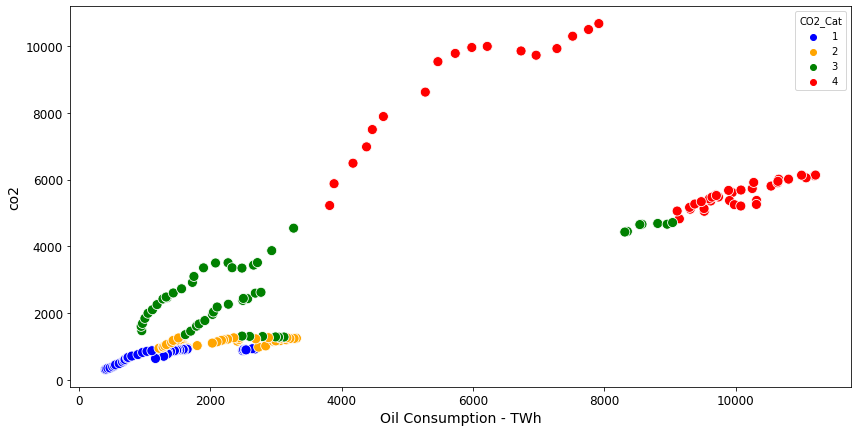

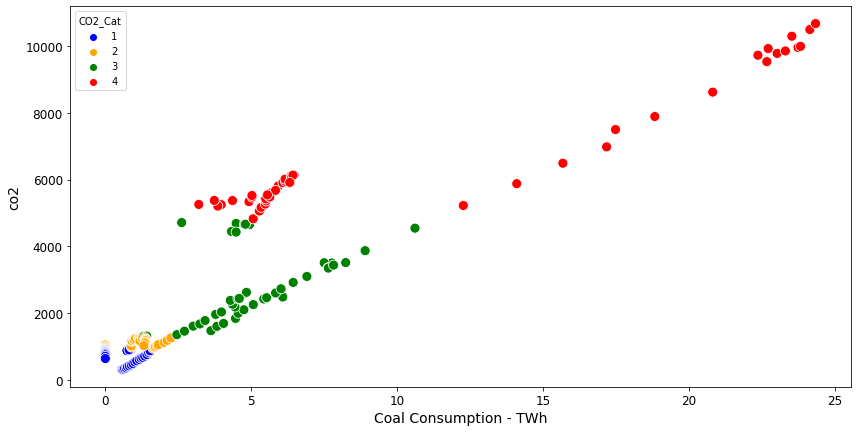

In [33]:
features = ['population', 'gdp', 'primary_energy_consumption', \
          'Coal Production - TWh', 'Oil Consumption - TWh', 'Coal Consumption - TWh']

for i in features:
    fig, ax = plt.subplots(figsize=(14,7))
    ax=sns.scatterplot(y='co2', x =i, hue='CO2_Cat',
                      palette= {1:"blue", 2: "orange", 3:"green", 4: "red"},
                      data=option_4, legend='full', s=100)

#### Plotting features against Categories

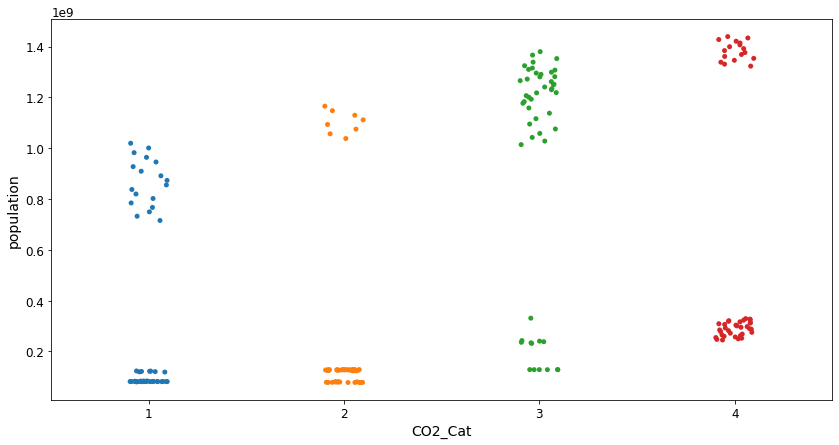

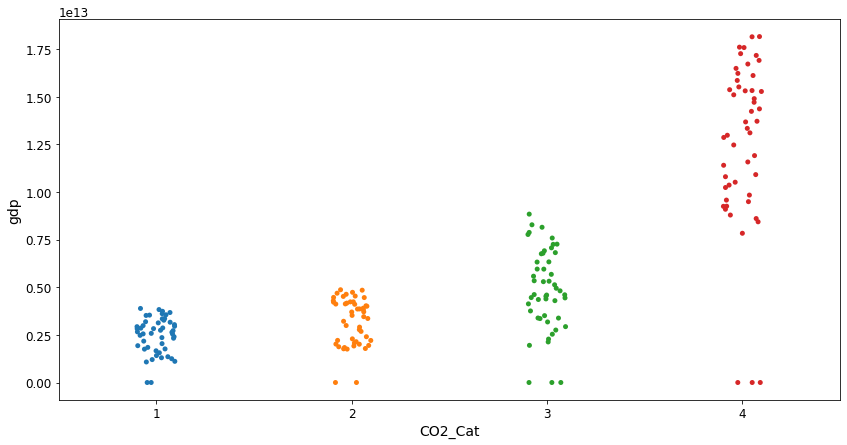

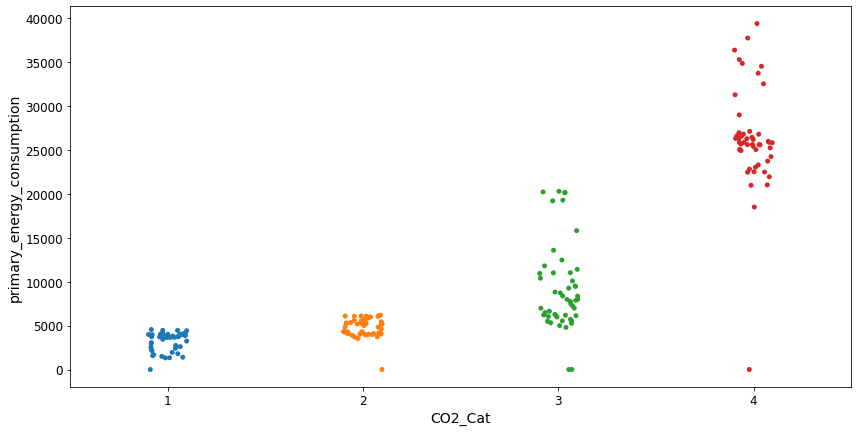

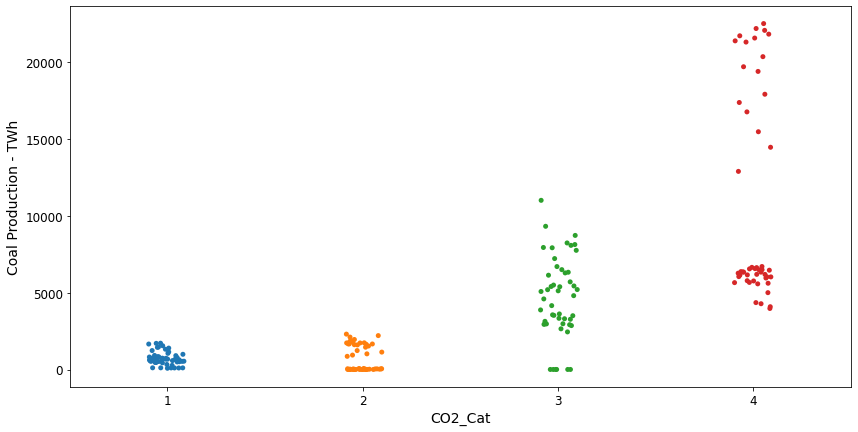

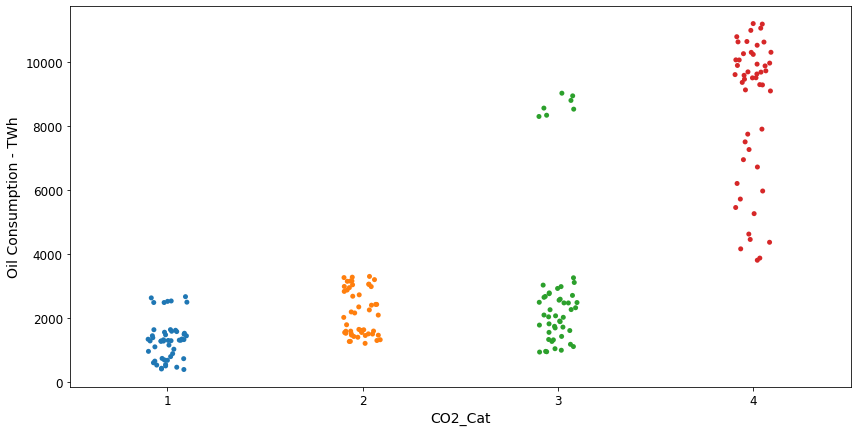

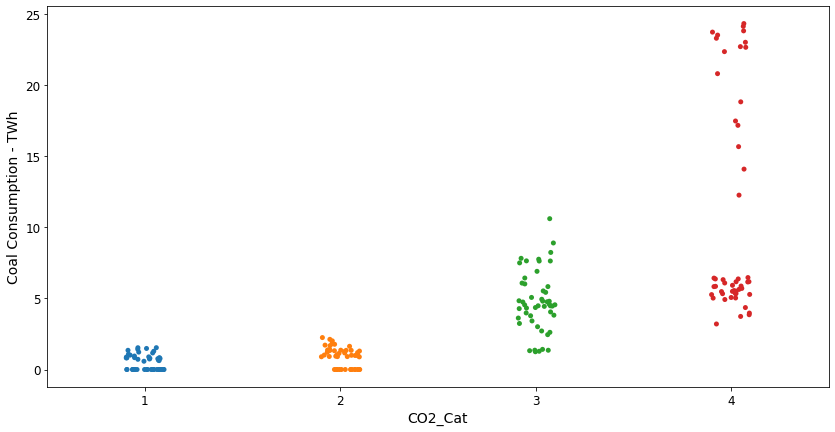

In [34]:
features = ['population', 'gdp', 'primary_energy_consumption', \
          'Coal Production - TWh', 'Oil Consumption - TWh', 'Coal Consumption - TWh']

for i in features:
    fig, ax = plt.subplots(figsize=(14,7))
    sns.stripplot(x="CO2_Cat", y=i, data=option_4);

In [35]:
datadrop = option_4.loc[option_4["Cars Produced - Thousands"]=="U"]
option_4 = option_4.drop(datadrop.index)

X = option_4.drop(["country","index","year","co2","Target_Rank","CO2_Cat"],axis=1)
colnames= X.columns
X = option_4.drop(["country","index","year","co2","Target_Rank","CO2_Cat"],axis=1).values
y = option_4["co2"].values

In [36]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

## K-Means Clustering

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Using Elbow Method to find optimal number of clusters

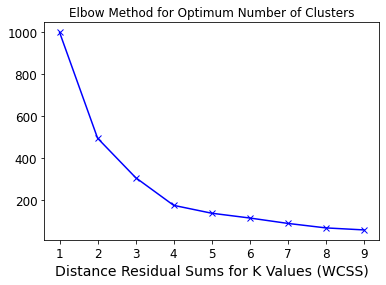

In [38]:
# Elbow
kmeans = KMeans()
ssd = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(x_train)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

#### Inspect Elbow Method further by generating silhouette score

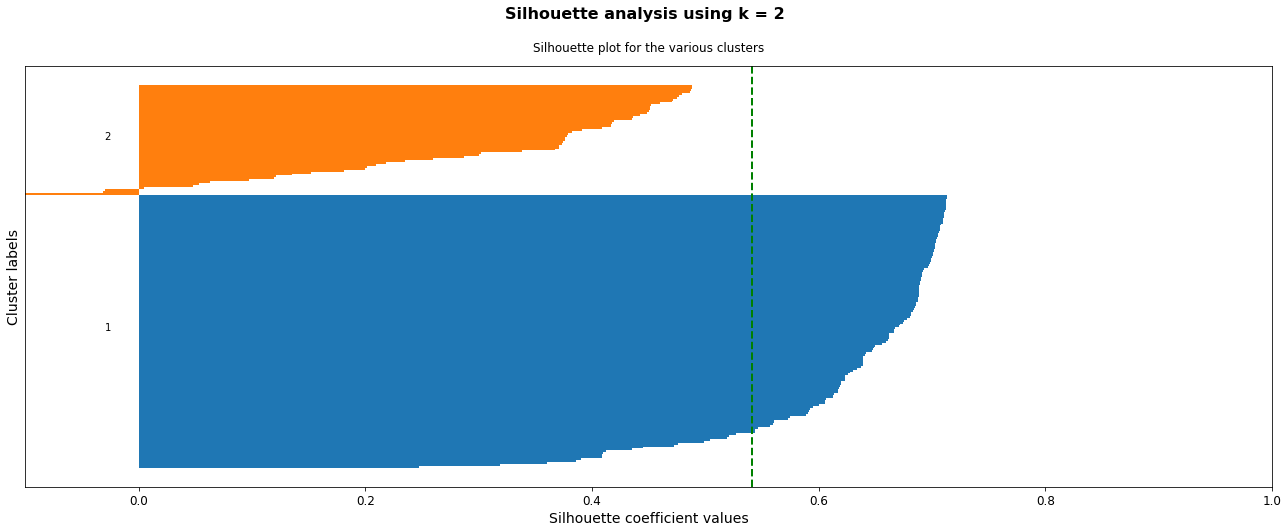

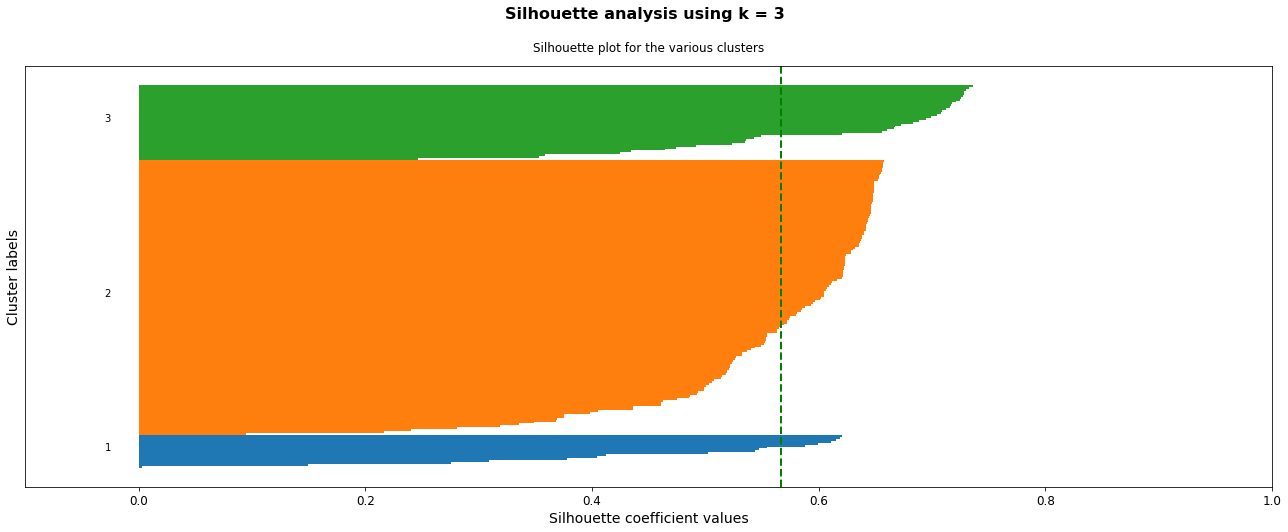

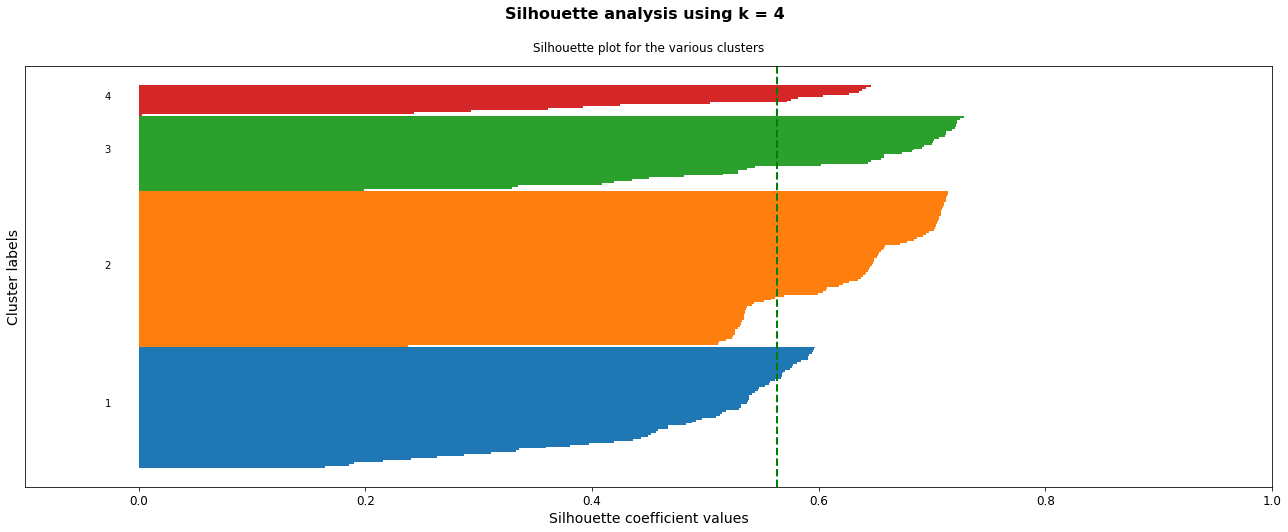

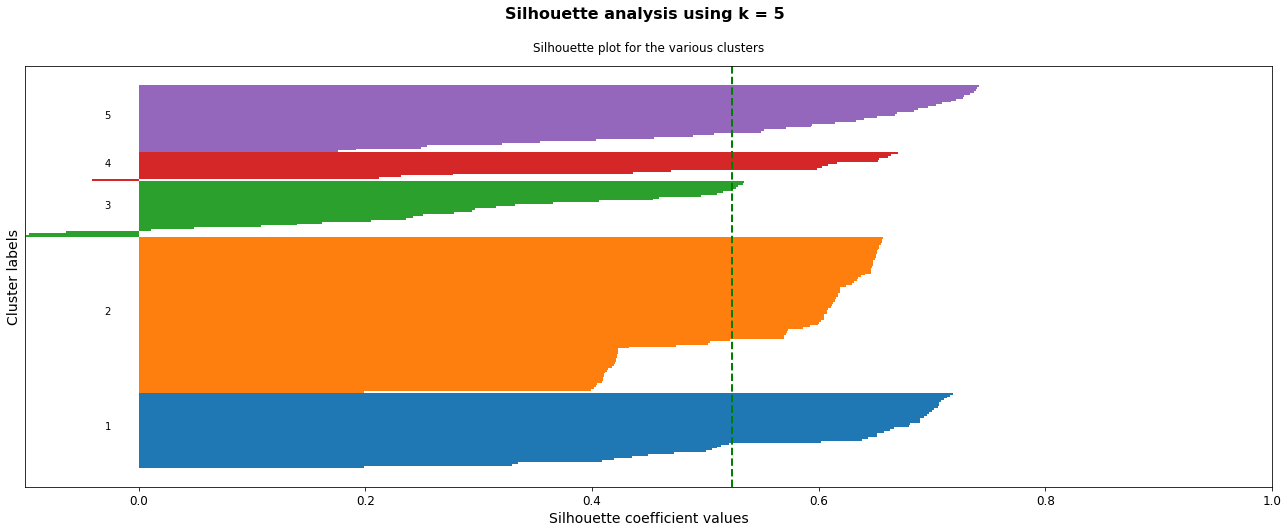

In [39]:
## silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([2, 3, 4,5]):
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

<div class="alert alert-block alert-success"><b>Silhouette Analysis Shows good results on both 3 and 4 clusters</b>

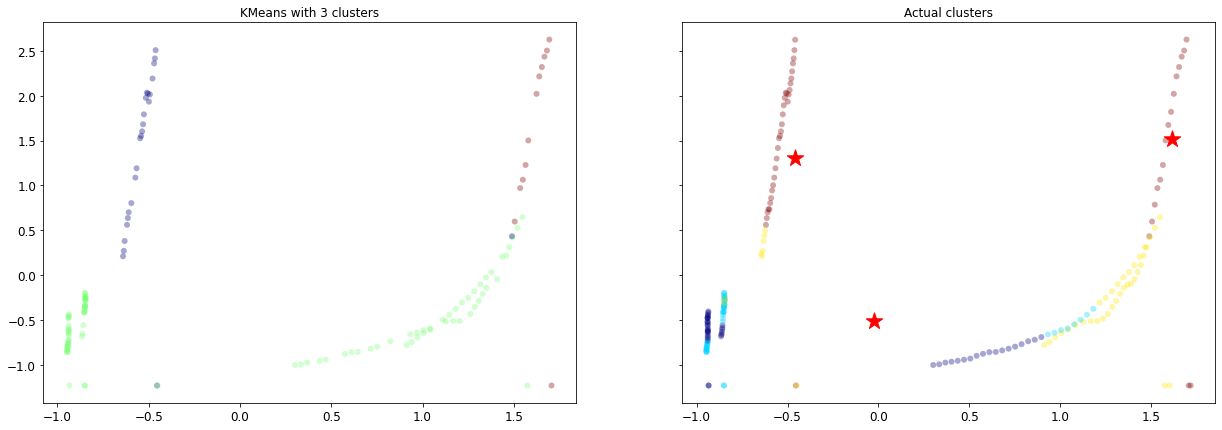

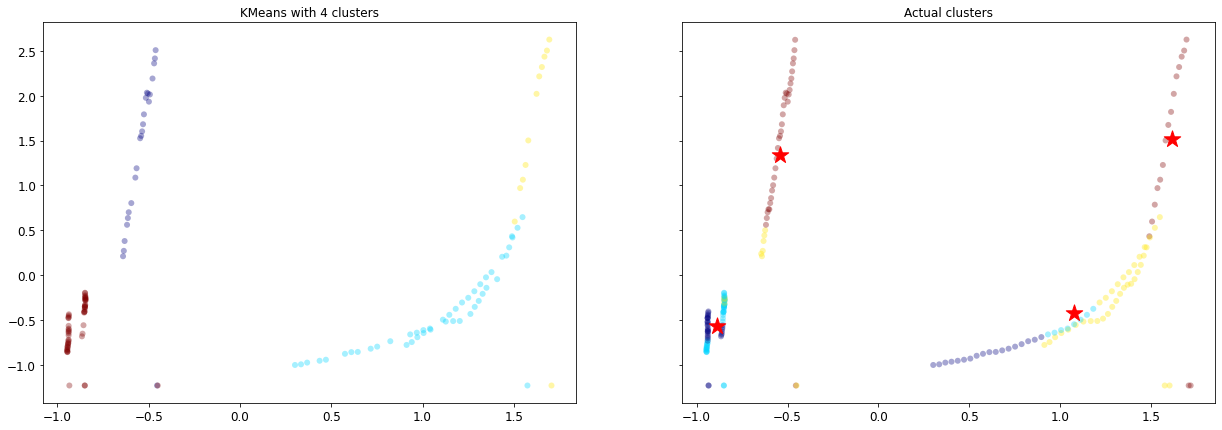

In [40]:
# KMeans for 3 & 4 Clusters
for i in range(3,5):
    kmns = KMeans(n_clusters=i, init='k-means++', n_init=40, max_iter=100, tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='auto')
    kY = kmns.fit_predict(x_train)
    centroids = kmns.cluster_centers_

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(21,7))

    ax1.scatter(x_train[:,0],x_train[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
    ax1.set_title(f'KMeans with {i} clusters')

    ax2.scatter(X[:,0],X[:,1],  c = option_4['CO2_Cat'], cmap = "jet", edgecolor = "None", alpha=0.35)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
                c='r', label='centroid')
    ax2.set_title('Actual clusters');

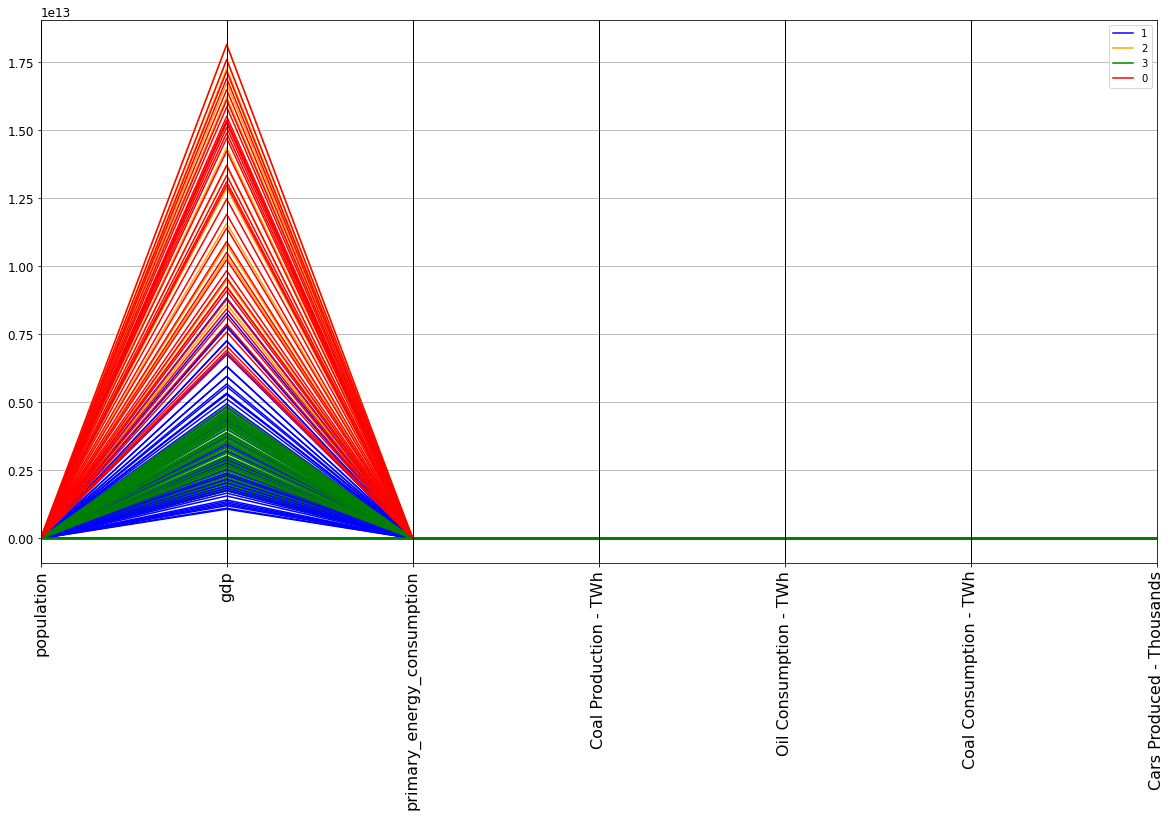

In [41]:
cols = option_4[['population', 'gdp', 'primary_energy_consumption',
       'Coal Production - TWh', 'Oil Consumption - TWh',
       'Coal Consumption - TWh', 'Cars Produced - Thousands']]
predict = kmns.predict(X)
cols['cluster'] = predict
plt.figure(figsize=(20,10))
pd.plotting.parallel_coordinates(cols, 'cluster', color=('blue','orange','green','red'))
plt.xticks(rotation = 90, fontsize = 16);

## Lasso

In [42]:
from sklearn.linear_model import Lasso

alpha_levels = [1.0, 0.5, 0.2, 0.1]

for i in alpha_levels:
    lasso = Lasso(normalize=True, alpha = i)
    lasso.fit(x_train,y_train)
    coeff_df = pd.DataFrame(lasso.coef_, colnames, columns=['Coefficient'])  
    display(coeff_df)
    print(f'Alpha level: {i}')
    
    score_model(lasso, x_train, y_train, x_test, y_test)
    
    ## Cross validation Scoring, 10-fold
    cv_scores = cross_val_score(lasso, X, y, cv = 10)
    print()
    print("#### Cross validation Scoring, 10-fold ####")
    print(cv_scores)
    print(f'Average 10-Fold CV Score: {np.mean(cv_scores):.4f}')
    print()
    print()
   

,Coefficient
population,0.000000
gdp,14.134895
primary_energy_consumption,1.129652
Coal Production - TWh,1333.135532
Oil Consumption - TWh,1128.792099
Coal Consumption - TWh,415.048009
Cars Produced - Thousands,125.615408


Alpha level: 1.0
#### Training dataset scores ####
The intercept for model is 2802.8922
Mean Absolute Error: 99.726195
Mean Squared Error: 16300.263203
Root Mean Squared Error: 127.672484
R2 score: 0.997558

Training dataset validation
      Actual  Predictions
0   1279.120      1391.79
1   9952.744      9789.02
2   3100.002      2978.78
3   9920.459      9876.65
4   2433.856      2200.16
5   1033.245       964.14
6    795.610       743.57
7   1204.993      1411.75
8   1244.781      1475.20
9    956.132       863.50
10  1259.744      1348.47
11  4429.187      4413.85
12  1011.605       960.68
13  2382.223      2141.36
14  1780.130      1767.82
15  7496.832      7376.96
16  1227.273      1428.55
17   951.749      1016.16
18  4825.445      4943.75
19  1844.828      1860.95


#### Testing dataset scores ####
The intercept for model is 2802.8922
Mean Absolute Error: 102.283338
Mean Squared Error: 14754.464611
Root Mean Squared Error: 121.467957
R2 score: 0.997714

Testing dataset validatio

,Coefficient
population,0.000000
gdp,13.847278
primary_energy_consumption,0.000000
Coal Production - TWh,1344.403334
Oil Consumption - TWh,1132.568680
Coal Consumption - TWh,406.922129
Cars Produced - Thousands,129.299644


Alpha level: 0.5
#### Training dataset scores ####
The intercept for model is 2802.9195
Mean Absolute Error: 98.984323
Mean Squared Error: 16139.649950
Root Mean Squared Error: 127.041922
R2 score: 0.997583

Training dataset validation
      Actual  Predictions
0   1279.120      1389.83
1   9952.744      9807.53
2   3100.002      2976.54
3   9920.459      9898.17
4   2433.856      2196.05
5   1033.245       959.88
6    795.610       740.26
7   1204.993      1410.16
8   1244.781      1474.21
9    956.132       858.08
10  1259.744      1343.33
11  4429.187      4415.50
12  1011.605       956.40
13  2382.223      2137.38
14  1780.130      1763.61
15  7496.832      7386.41
16  1227.273      1427.40
17   951.749      1009.76
18  4825.445      4946.91
19  1844.828      1855.68


#### Testing dataset scores ####
The intercept for model is 2802.9195
Mean Absolute Error: 101.577262
Mean Squared Error: 14646.825508
Root Mean Squared Error: 121.024070
R2 score: 0.997731

Testing dataset validatio

,Coefficient
population,5.719129
gdp,12.608030
primary_energy_consumption,0.000000
Coal Production - TWh,1358.631505
Oil Consumption - TWh,1136.640111
Coal Consumption - TWh,388.163229
Cars Produced - Thousands,135.185935


Alpha level: 0.2
#### Training dataset scores ####
The intercept for model is 2802.7609
Mean Absolute Error: 99.348903
Mean Squared Error: 16069.775256
Root Mean Squared Error: 126.766617
R2 score: 0.997593

Training dataset validation
      Actual  Predictions
0   1279.120      1387.42
1   9952.744      9814.95
2   3100.002      2976.60
3   9920.459      9912.30
4   2433.856      2198.10
5   1033.245       954.28
6    795.610       736.77
7   1204.993      1408.48
8   1244.781      1473.37
9    956.132       850.92
10  1259.744      1345.48
11  4429.187      4412.16
12  1011.605       950.77
13  2382.223      2139.82
14  1780.130      1766.39
15  7496.832      7388.82
16  1227.273      1426.38
17   951.749      1009.70
18  4825.445      4944.53
19  1844.828      1853.27


#### Testing dataset scores ####
The intercept for model is 2802.7609
Mean Absolute Error: 101.192279
Mean Squared Error: 14645.905547
Root Mean Squared Error: 121.020269
R2 score: 0.997731

Testing dataset validatio

,Coefficient
population,9.124839
gdp,11.929908
primary_energy_consumption,-0.000000
Coal Production - TWh,1365.757080
Oil Consumption - TWh,1138.547663
Coal Consumption - TWh,377.925247
Cars Produced - Thousands,138.162892


Alpha level: 0.1
#### Training dataset scores ####
The intercept for model is 2802.6651
Mean Absolute Error: 99.694451
Mean Squared Error: 16056.297188
Root Mean Squared Error: 126.713445
R2 score: 0.997595

Training dataset validation
      Actual  Predictions
0   1279.120      1386.25
1   9952.744      9816.49
2   3100.002      2976.99
3   9920.459      9917.34
4   2433.856      2199.89
5   1033.245       951.69
6    795.610       735.25
7   1204.993      1407.71
8   1244.781      1473.00
9    956.132       847.54
10  1259.744      1347.57
11  4429.187      4409.86
12  1011.605       948.16
13  2382.223      2141.85
14  1780.130      1768.68
15  7496.832      7388.80
16  1227.273      1425.95
17   951.749      1010.66
18  4825.445      4942.59
19  1844.828      1852.65


#### Testing dataset scores ####
The intercept for model is 2802.6651
Mean Absolute Error: 101.049964
Mean Squared Error: 14669.997112
Root Mean Squared Error: 121.119764
R2 score: 0.997727

Testing dataset validatio

#### Plot below shows population,gdp and cars produced are not as important variables compared to others that drives CO2 emission

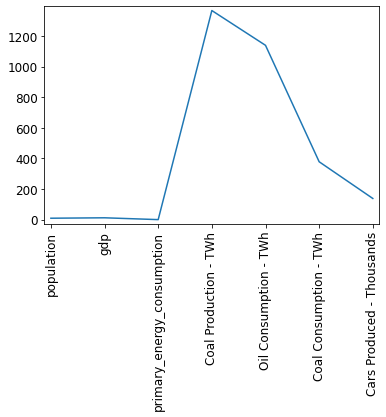

In [43]:
# Plot the coefficients
plt.plot(range(len(colnames)), lasso.coef_);
plt.xticks(range(len(colnames)), colnames.values, rotation=90);
plt.margins(0.02)
plt.show()

### Ridge

In [44]:
alpha_levels = [1.0, 0.5, 0.2, 0.1]

for i in alpha_levels:
    ridge = linear_model.Ridge(alpha = i)
    ridge.fit(x_train,y_train)
    coeff_df = pd.DataFrame(ridge.coef_, colnames, columns=['Coefficient'])  
    display(coeff_df)
    print(f'Alpha level: {i}')
    
    score_model(ridge, x_train, y_train, x_test, y_test)
    
    ## Cross validation Scoring, 10-fold
    cv_scores = cross_val_score(ridge, X, y, cv = 10)
    print()
    print("#### Cross validation Scoring, 10-fold ####")
    print(cv_scores)
    print(f'Average 10-Fold CV Score: {np.mean(cv_scores)}')

,Coefficient
population,2.236151
gdp,12.181993
primary_energy_consumption,163.364583
Coal Production - TWh,1070.465313
Oil Consumption - TWh,1044.741505
Coal Consumption - TWh,597.179239
Cars Produced - Thousands,103.225496


Alpha level: 1.0
#### Training dataset scores ####
The intercept for model is 2799.5274
Mean Absolute Error: 102.191152
Mean Squared Error: 18217.451642
Root Mean Squared Error: 134.972040
R2 score: 0.997271

Training dataset validation
      Actual  Predictions
0   1279.120      1417.12
1   9952.744      9796.81
2   3100.002      2970.37
3   9920.459      9919.65
4   2433.856      2249.10
5   1033.245       916.24
6    795.610       727.16
7   1204.993      1425.67
8   1244.781      1486.53
9    956.132       839.64
10  1259.744      1348.32
11  4429.187      4427.59
12  1011.605       911.25
13  2382.223      2180.54
14  1780.130      1787.15
15  7496.832      7372.59
16  1227.273      1433.72
17   951.749      1017.72
18  4825.445      4944.37
19  1844.828      1854.61


#### Testing dataset scores ####
The intercept for model is 2799.5274
Mean Absolute Error: 117.175184
Mean Squared Error: 22585.301849
Root Mean Squared Error: 150.284071
R2 score: 0.996500

Testing dataset validati

,Coefficient
population,2.179003
gdp,13.967675
primary_energy_consumption,71.709974
Coal Production - TWh,1176.271720
Oil Consumption - TWh,1098.113901
Coal Consumption - TWh,540.302305
Cars Produced - Thousands,113.645512


Alpha level: 0.5
#### Training dataset scores ####
The intercept for model is 2801.4537
Mean Absolute Error: 101.447576
Mean Squared Error: 16816.971590
Root Mean Squared Error: 129.680267
R2 score: 0.997481

Training dataset validation
      Actual  Predictions
0   1279.120      1407.31
1   9952.744      9810.67
2   3100.002      2972.29
3   9920.459      9919.10
4   2433.856      2231.27
5   1033.245       925.28
6    795.610       725.39
7   1204.993      1420.63
8   1244.781      1483.24
9    956.132       840.54
10  1259.744      1345.81
11  4429.187      4426.55
12  1011.605       921.31
13  2382.223      2166.18
14  1780.130      1778.73
15  7496.832      7380.89
16  1227.273      1433.10
17   951.749      1013.71
18  4825.445      4950.80
19  1844.828      1854.78


#### Testing dataset scores ####
The intercept for model is 2801.4537
Mean Absolute Error: 109.845320
Mean Squared Error: 16332.754247
Root Mean Squared Error: 127.799665
R2 score: 0.997469

Testing dataset validati

,Coefficient
population,4.909361
gdp,16.886846
primary_energy_consumption,-1.539772
Coal Production - TWh,1283.157636
Oil Consumption - TWh,1138.850706
Coal Consumption - TWh,467.415979
Cars Produced - Thousands,126.695946


Alpha level: 0.2
#### Training dataset scores ####
The intercept for model is 2802.8278
Mean Absolute Error: 100.787882
Mean Squared Error: 16141.147431
Root Mean Squared Error: 127.047816
R2 score: 0.997582

Training dataset validation
      Actual  Predictions
0   1279.120      1397.47
1   9952.744      9819.95
2   3100.002      2974.21
3   9920.459      9920.07
4   2433.856      2216.63
5   1033.245       935.31
6    795.610       727.35
7   1204.993      1415.47
8   1244.781      1479.89
9    956.132       841.44
10  1259.744      1346.46
11  4429.187      4418.46
12  1011.605       932.06
13  2382.223      2155.05
14  1780.130      1773.79
15  7496.832      7385.97
16  1227.273      1431.96
17   951.749      1011.64
18  4825.445      4949.19
19  1844.828      1854.10


#### Testing dataset scores ####
The intercept for model is 2802.8278
Mean Absolute Error: 103.501602
Mean Squared Error: 14543.522649
Root Mean Squared Error: 120.596528
R2 score: 0.997747

Testing dataset validati

,Coefficient
population,6.853589
gdp,18.321480
primary_energy_consumption,-30.532468
Coal Production - TWh,1333.019348
Oil Consumption - TWh,1154.519725
Coal Consumption - TWh,429.519380
Cars Produced - Thousands,133.368508


Alpha level: 0.1
#### Training dataset scores ####
The intercept for model is 2803.3242
Mean Absolute Error: 100.575262
Mean Squared Error: 15997.143761
Root Mean Squared Error: 126.479816
R2 score: 0.997604

Training dataset validation
      Actual  Predictions
0   1279.120      1392.81
1   9952.744      9823.15
2   3100.002      2975.14
3   9920.459      9920.88
4   2433.856      2210.44
5   1033.245       940.28
6    795.610       729.12
7   1204.993      1412.97
8   1244.781      1478.23
9    956.132       841.90
10  1259.744      1347.46
11  4429.187      4413.16
12  1011.605       937.28
13  2382.223      2150.51
14  1780.130      1772.24
15  7496.832      7387.65
16  1227.273      1431.22
17   951.749      1011.11
18  4825.445      4946.63
19  1844.828      1853.59


#### Testing dataset scores ####
The intercept for model is 2803.3242
Mean Absolute Error: 103.854884
Mean Squared Error: 14618.863327
Root Mean Squared Error: 120.908492
R2 score: 0.997735

Testing dataset validati

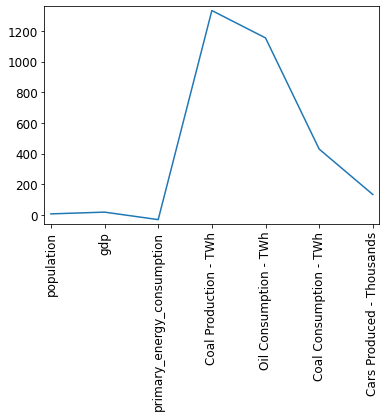

In [45]:
# Plot the coefficients
plt.plot(range(len(colnames)), ridge.coef_);
plt.xticks(range(len(colnames)), colnames.values, rotation=90);
plt.margins(0.02)
plt.show()

### ElasticNet

In [46]:
from sklearn.linear_model import ElasticNet

alpha_levels = [1.0, 0.5, 0.2, 0.1]

for i in alpha_levels:
    elastic = ElasticNet(random_state=42, alpha = i)
    elastic.fit(x_train, y_train)
    coeff_df = pd.DataFrame(elastic.coef_, colnames, columns=['Coefficient'])  
    display(coeff_df)
    print(f'Alpha level: {i}')
    
    score_model(elastic, x_train, y_train, x_test, y_test)

,Coefficient
population,123.294960
gdp,282.534883
primary_energy_consumption,535.302675
Coal Production - TWh,535.153726
Oil Consumption - TWh,499.264804
Coal Consumption - TWh,490.626760
Cars Produced - Thousands,215.936038


Alpha level: 1.0
#### Training dataset scores ####
The intercept for model is 2776.8102
Mean Absolute Error: 321.260374
Mean Squared Error: 174675.238263
Root Mean Squared Error: 417.941668
R2 score: 0.973836

Training dataset validation
      Actual  Predictions
0   1279.120      1689.54
1   9952.744      9151.86
2   3100.002      2892.62
3   9920.459      9612.13
4   2433.856      2724.92
5   1033.245       898.74
6    795.610      1057.89
7   1204.993      1668.75
8   1244.781      1733.60
9    956.132       873.78
10  1259.744      1661.78
11  4429.187      3790.34
12  1011.605       886.57
13  2382.223      2625.21
14  1780.130      2169.75
15  7496.832      6769.78
16  1227.273      1658.12
17   951.749      1277.36
18  4825.445      4226.36
19  1844.828      1868.87


#### Testing dataset scores ####
The intercept for model is 2776.8102
Mean Absolute Error: 353.123125
Mean Squared Error: 361251.967092
Root Mean Squared Error: 601.042400
R2 score: 0.944025

Testing dataset valida

,Coefficient
population,96.590767
gdp,218.441949
primary_energy_consumption,569.978265
Coal Production - TWh,610.938983
Oil Consumption - TWh,587.866106
Coal Consumption - TWh,540.375922
Cars Produced - Thousands,177.518457


Alpha level: 0.5
#### Training dataset scores ####
The intercept for model is 2780.5434
Mean Absolute Error: 218.471451
Mean Squared Error: 95144.220377
Root Mean Squared Error: 308.454568
R2 score: 0.985749

Training dataset validation
      Actual  Predictions
0   1279.120      1588.79
1   9952.744      9445.26
2   3100.002      2917.78
3   9920.459      9841.16
4   2433.856      2612.50
5   1033.245       860.71
6    795.610       933.62
7   1204.993      1571.73
8   1244.781      1634.31
9    956.132       825.33
10  1259.744      1557.36
11  4429.187      3991.55
12  1011.605       848.55
13  2382.223      2516.35
14  1780.130      2062.10
15  7496.832      7017.42
16  1227.273      1560.32
17   951.749      1178.21
18  4825.445      4453.44
19  1844.828      1843.56


#### Testing dataset scores ####
The intercept for model is 2780.5434
Mean Absolute Error: 250.598990
Mean Squared Error: 245837.775730
Root Mean Squared Error: 495.820306
R2 score: 0.961908

Testing dataset validat

,Coefficient
population,56.101896
gdp,116.064797
primary_energy_consumption,559.621428
Coal Production - TWh,710.732535
Oil Consumption - TWh,708.369154
Coal Consumption - TWh,595.888671
Cars Produced - Thousands,129.781999


Alpha level: 0.2
#### Training dataset scores ####
The intercept for model is 2785.9478
Mean Absolute Error: 137.039217
Mean Squared Error: 48506.847340
Root Mean Squared Error: 220.242701
R2 score: 0.992734

Training dataset validation
      Actual  Predictions
0   1279.120      1500.84
1   9952.744      9633.85
2   3100.002      2944.96
3   9920.459      9927.64
4   2433.856      2457.21
5   1033.245       871.30
6    795.610       828.69
7   1204.993      1490.10
8   1244.781      1549.21
9    956.132       821.96
10  1259.744      1454.00
11  4429.187      4210.72
12  1011.605       860.19
13  2382.223      2370.07
14  1780.130      1936.48
15  7496.832      7210.48
16  1227.273      1480.54
17   951.749      1095.86
18  4825.445      4691.26
19  1844.828      1840.84


#### Testing dataset scores ####
The intercept for model is 2785.9478
Mean Absolute Error: 163.896338
Mean Squared Error: 151561.367186
Root Mean Squared Error: 389.308833
R2 score: 0.976516

Testing dataset validat

,Coefficient
population,31.792613
gdp,57.478043
primary_energy_consumption,495.061668
Coal Production - TWh,789.623418
Oil Consumption - TWh,802.721630
Coal Consumption - TWh,626.635037
Cars Produced - Thousands,107.314705


Alpha level: 0.1
#### Training dataset scores ####
The intercept for model is 2789.9714
Mean Absolute Error: 110.676155
Mean Squared Error: 33154.289130
Root Mean Squared Error: 182.083193
R2 score: 0.995034

Training dataset validation
      Actual  Predictions
0   1279.120      1462.64
1   9952.744      9704.68
2   3100.002      2957.71
3   9920.459      9933.00
4   2433.856      2367.05
5   1033.245       887.69
6    795.610       780.23
7   1204.993      1456.84
8   1244.781      1514.81
9    956.132       830.10
10  1259.744      1402.78
11  4429.187      4321.53
12  1011.605       878.00
13  2382.223      2286.31
14  1780.130      1868.59
15  7496.832      7290.27
16  1227.273      1450.74
17   951.749      1059.04
18  4825.445      4811.72
19  1844.828      1845.71


#### Testing dataset scores ####
The intercept for model is 2789.9714
Mean Absolute Error: 140.163275
Mean Squared Error: 99986.683757
Root Mean Squared Error: 316.206710
R2 score: 0.984507

Testing dataset validati

#### Plot below shows all variables besides population,gdp and car produced are important variables that determine emission

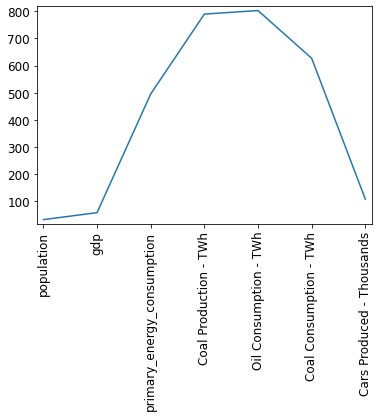

In [47]:
# Plot the coefficients
plt.plot(range(len(colnames)), elastic.coef_);
plt.xticks(range(len(colnames)), colnames.values, rotation=90);
plt.margins(0.02)
plt.show()

### Random Forest Regressor

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# param_grid = {
#                  'n_estimators': [5, 10, 15, 20, 100, 250, 500, 750, 1000],
#                  'max_depth': [2, 5, 7, 9, 50, 100, 1000]
#              }

forest = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=9, n_estimators=500)

# grid = GridSearchCV(forest, param_grid, cv=10, n_jobs=-1)
# grid.fit(x_train, y_train)

forest.fit(x_train, y_train)

score_model(forest, x_train, y_train, x_test, y_test)

# Cross validation Scoring, 10-fold
cv_scores = cross_val_score(forest, X, y, cv = 10)
print()
print("#### Cross validation Scoring, 10-fold ####")
print(cv_scores)
print(f'Average 10-Fold CV Score: {np.mean(cv_scores)}')

# # Print best params from GridSearchCV
# print()
# print(f'Best Params: {grid.best_params_}')

#### Training dataset scores ####
Mean Absolute Error: 34.705955
Mean Squared Error: 9132.452850
Root Mean Squared Error: 95.563868
R2 score: 0.998632

Training dataset validation
      Actual  Predictions
0   1279.120      1263.98
1   9952.744      9940.76
2   3100.002      3102.93
3   9920.459      9936.89
4   2433.856      2452.55
5   1033.245      1031.61
6    795.610       798.76
7   1204.993      1221.29
8   1244.781      1356.46
9    956.132       954.95
10  1259.744      1254.34
11  4429.187      4482.59
12  1011.605      1011.31
13  2382.223      2356.94
14  1780.130      1814.32
15  7496.832      7345.14
16  1227.273      1218.70
17   951.749       935.33
18  4825.445      4864.26
19  1844.828      1873.94


#### Testing dataset scores ####
Mean Absolute Error: 130.286545
Mean Squared Error: 253299.264402
Root Mean Squared Error: 503.288450
R2 score: 0.960752

Testing dataset validation
      Actual  Predictions
0    361.889       373.82
1   3510.169      3398.53
2   2036.937